In [29]:
# Cell 1: Install dependencies
!pip install -q torch torchvision torchaudio
!pip install -q roboflow
!pip install -q kaggle
!pip install -q timm  # For advanced feature extractors
!pip install -q albumentations  # For advanced augmentations
!pip install -q opencv-python-headless
!pip install -q PyYAML
!pip install -q onnx

# Clone YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 98.5 MB/s eta 0:00:00
Cloning into 'yolov5'...
remote: Enumerating objects: 17726, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 17726 (delta 50), reused 29 (delta 29), pack-reused 17642 (from 3)
Receiving objects: 100% (17726/17726), 17.12 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (12047/12047), done.
/content/yolov5/yolov5


In [2]:
# Cell 2: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import cv2
import numpy as np
import yaml
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
import shutil
from datetime import datetime

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


In [3]:
import os

# Create folder
os.makedirs("plantdoc_raw", exist_ok=True)

# Download PlantDoc dataset (images + annotations)
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git plantdoc_raw

print("✅ PlantDoc dataset downloaded successfully from GitHub!")


Cloning into 'plantdoc_raw'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 49.03 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.
✅ PlantDoc dataset downloaded successfully from GitHub!


In [4]:
# Cell 4: Innovative Data Preprocessing Pipeline
# Using Attention-based Multi-Scale Feature Extraction

class AttentionFeatureExtractor(nn.Module):
    """
    Custom attention mechanism to enhance disease feature detection
    Combines spatial and channel attention for better multi-label classification
    """
    def __init__(self, in_channels):
        super(AttentionFeatureExtractor, self).__init__()

        # Channel Attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 8, in_channels, 1),
            nn.Sigmoid()
        )

        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(spatial_input)
        x = x * sa

        return x

print("Attention Feature Extractor defined!")

Attention Feature Extractor defined!


In [6]:
# ============================================================
# Cell 5: Convert PlantDoc to YOLOv5 format with multi-label support
# ============================================================
import os
import json
import shutil
import random
from pathlib import Path
from collections import defaultdict, Counter

random.seed(42)

def convert_plantdoc_to_yolo(
    source_root="plantdoc_raw",
    out_root="plantdoc_yolo",
    train_ratio=0.8,
    multilabel_json_rel="image_labels.json",  # optional file at plantdoc_raw/image_labels.json
):
    """
    Convert PlantDoc-style folder dataset to YOLO format.

    - Expects images grouped in class folders (single-label by default).
    - If an optional JSON mapping exists at `<source_root>/<multilabel_json_rel>`,
      it can assign multiple classes per image (multi-label).
      Format:
      {
        "ClassName/imagename.jpg": ["ClassName", "AnotherClass"],
        "subdir/ClassName/img.png": ["ClassName"]
      }

    YOLO label per line: <class_id> <x_center> <y_center> <width> <height>
    We use a full-image box (0.5 0.5 1 1) for image-level labels.
    """

    source_dir = Path(source_root)

    # Support either `plantdoc_raw/PlantDoc-Dataset` (some repos) or just `plantdoc_raw`
    if (source_dir / "PlantDoc-Dataset").exists():
        source_dir = source_dir / "PlantDoc-Dataset"

    if not source_dir.exists():
        raise FileNotFoundError(f"Source directory not found: {source_dir}")

    out_dir = Path(out_root)
    for split in ["train", "val"]:
        (out_dir / split / "images").mkdir(parents=True, exist_ok=True)
        (out_dir / split / "labels").mkdir(parents=True, exist_ok=True)

    # Load optional multi-label mapping
    multilabel_path = Path(source_root) / multilabel_json_rel
    user_multilabel = {}
    if multilabel_path.exists():
        with open(multilabel_path, "r", encoding="utf-8") as f:
            user_multilabel = json.load(f)
        print(f"Loaded optional multi-label mapping: {multilabel_path}")

    # Gather images and infer classes from folder names
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".JPG", ".JPEG", ".PNG"}
    images = []
    class_names_set = set()

    # Walk: class folders may be directly under source_dir (ClassName/xxx.jpg)
    for p in source_dir.rglob("*"):
        if p.is_file() and p.suffix in exts:
            # class is the immediate parent folder name
            parent_class = p.parent.name
            class_names_set.add(parent_class)

            # Build a relative key for optional multi-label mapping
            try:
                rel_key = str(p.relative_to(source_dir)).replace("\\", "/")
            except Exception:
                rel_key = p.name

            images.append({
                "path": p,
                "class_from_folder": parent_class,
                "rel_key": rel_key
            })

    if not images:
        raise RuntimeError(f"No images found under {source_dir}")

    class_names = sorted(class_names_set)
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    print(f"Found {len(class_names)} classes:")
    for idx, name in enumerate(class_names):
        print(f"  {idx}: {name}")

    # Determine labels per image (single-label from folder, unless overridden/extended by JSON)
    # The JSON can list ONE or MANY classes for a given image (multi-label).
    img_records = []
    missing_classes = set()

    for rec in images:
        labels = None
        # If user provided JSON has labels for this image, use those
        if rec["rel_key"] in user_multilabel:
            labels = user_multilabel[rec["rel_key"]]
        else:
            # default: single label = folder name
            labels = [rec["class_from_folder"]]

        # Validate and map to indices
        idxs = []
        for c in labels:
            if c not in class_to_idx:
                missing_classes.add(c)
                continue
            idxs.append(class_to_idx[c])

        if not idxs:
            # If everything failed (e.g., only unknown classes), fallback to folder class if valid
            c = rec["class_from_folder"]
            if c in class_to_idx:
                idxs = [class_to_idx[c]]
            else:
                continue  # skip if truly unmapped

        img_records.append({
            "path": rec["path"],
            "labels": sorted(set(idxs))
        })

    if missing_classes:
        print(f"Warning: {len(missing_classes)} class names from JSON not present in folders: {sorted(missing_classes)[:10]}{' ...' if len(missing_classes) > 10 else ''}")

    # Simple per-class balanced split:
    # Group images by their PRIMARY class (first label) just to approximate balance
    by_primary = defaultdict(list)
    for r in img_records:
        primary = r["labels"][0]
        by_primary[primary].append(r)

    train_list, val_list = [], []
    for primary_cls, items in by_primary.items():
        random.shuffle(items)
        k = int(len(items) * train_ratio)
        train_list.extend(items[:k])
        val_list.extend(items[k:])

    # Deduplicate in case of overlap
    def uniqueize(records):
        seen = set()
        out = []
        for r in records:
            key = str(r["path"])
            if key in seen:
                continue
            seen.add(key)
            out.append(r)
        return out

    train_list = uniqueize(train_list)
    val_list = uniqueize(val_list)

    # In case one split is empty due to tiny classes, fix with random fallback
    if not train_list:
        train_list, val_list = img_records[: int(len(img_records)*train_ratio)], img_records[int(len(img_records)*train_ratio):]
    if not val_list:
        val_list = train_list[-1:]
        train_list = train_list[:-1]

    # Copy images and write YOLO label files
    def write_split(records, split_name):
        img_dst_dir = out_dir / split_name / "images"
        lbl_dst_dir = out_dir / split_name / "labels"

        collision_counter = Counter()
        for r in records:
            src = r["path"]
            # Avoid filename collisions across different class folders
            # Use parentfolder__filename.ext
            dst_name = f"{src.parent.name}__{src.name}"
            if dst_name in collision_counter:
                # If still collides, add a numeric suffix
                collision_counter[dst_name] += 1
                stem, ext = os.path.splitext(dst_name)
                dst_name = f"{stem}_{collision_counter[dst_name]}{ext}"
            else:
                collision_counter[dst_name] = 0

            dst_img = img_dst_dir / dst_name
            shutil.copy2(src, dst_img)

            # YOLO full-image bbox for each label (multi-label => multiple lines)
            x_center, y_center, width, height = 0.5, 0.5, 1.0, 1.0
            dst_lbl = lbl_dst_dir / f"{Path(dst_name).stem}.txt"
            with open(dst_lbl, "w", encoding="utf-8") as f:
                for cls_id in r["labels"]:
                    f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")

    write_split(train_list, "train")
    write_split(val_list, "val")

    # Create data.yaml for YOLOv5/YOLOv8
    data_yaml = out_dir / "data.yaml"
    data_yaml.write_text(
        "\n".join([
            f"path: {out_dir.resolve()}",
            "train: train/images",
            "val: val/images",
            f"nc: {len(class_names)}",
            "names: [" + ", ".join([f"'{c}'" for c in class_names]) + "]",
        ]) + "\n",
        encoding="utf-8"
    )

    print("\nDataset conversion complete!")
    print(f"Train images: {len(train_list)} | Val images: {len(val_list)}")
    print(f"Total classes: {len(class_names)}")

    return class_names, class_to_idx

class_names, class_to_idx = convert_plantdoc_to_yolo()


Found 29 classes:
  0: Apple Scab Leaf
  1: Apple leaf
  2: Apple rust leaf
  3: Bell_pepper leaf
  4: Bell_pepper leaf spot
  5: Blueberry leaf
  6: Cherry leaf
  7: Corn Gray leaf spot
  8: Corn leaf blight
  9: Corn rust leaf
  10: Peach leaf
  11: Potato leaf early blight
  12: Potato leaf late blight
  13: Raspberry leaf
  14: Soyabean leaf
  15: Squash Powdery mildew leaf
  16: Strawberry leaf
  17: Tomato Early blight leaf
  18: Tomato Septoria leaf spot
  19: Tomato leaf
  20: Tomato leaf bacterial spot
  21: Tomato leaf late blight
  22: Tomato leaf mosaic virus
  23: Tomato leaf yellow virus
  24: Tomato mold leaf
  25: Tomato two spotted spider mites leaf
  26: grape leaf
  27: grape leaf black rot
  28: plantdoc_raw

Dataset conversion complete!
Train images: 2049 | Val images: 530
Total classes: 29


In [7]:
# Cell 6: Create advanced YAML configuration with custom augmentation
yaml_content = f"""
path: /content/yolov5/plantdoc_yolo
train: train/images
val: val/images

nc: {len(class_names)}
names: {class_names}
"""

with open('plantdoc.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML configuration created!")
print("\nDataset configuration:")
print(yaml_content)

YAML configuration created!

Dataset configuration:

path: /content/yolov5/plantdoc_yolo
train: train/images
val: val/images

nc: 29
names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot', 'plantdoc_raw']



In [8]:
# Cell 7: Implement Hybrid YOLOv5 + EfficientNet Multi-Label Classifier
# This is a unique architecture combining object detection with classification

class HybridMultiLabelDetector(nn.Module):
    """
    Innovative hybrid architecture:
    - YOLOv5 for spatial feature extraction and localization
    - EfficientNet for enhanced feature representation
    - Multi-head attention for multi-label classification
    - Disease co-occurrence modeling
    """
    def __init__(self, num_classes, yolo_backbone):
        super(HybridMultiLabelDetector, self).__init__()

        # YOLOv5 backbone (frozen initially)
        self.yolo_backbone = yolo_backbone

        # EfficientNet auxiliary branch
        self.efficientnet = timm.create_model('efficientnet_b2', pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        # Feature fusion
        self.feature_fusion = nn.Sequential(
            nn.Linear(1408, 512),  # EfficientNet-B2 output
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Attention mechanism for multi-label
        self.attention = AttentionFeatureExtractor(512)

        # Multi-label classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

        # Disease co-occurrence matrix (learnable)
        self.disease_correlation = nn.Parameter(
            torch.eye(num_classes) * 0.1 +
            torch.randn(num_classes, num_classes) * 0.01
        )

    def forward(self, x):
        # Get features from EfficientNet
        features = self.efficientnet(x)
        features = self.feature_fusion(features)

        # Apply attention
        features = features.unsqueeze(-1).unsqueeze(-1)
        features = features.expand(-1, -1, 8, 8)
        features = self.attention(features)
        features = F.adaptive_avg_pool2d(features, 1).flatten(1)

        # Get logits
        logits = self.classifier(features)

        # Apply disease correlation
        correlated_logits = torch.matmul(logits, self.disease_correlation)

        return logits, correlated_logits

print("Hybrid Multi-Label Detector architecture defined!")

Hybrid Multi-Label Detector architecture defined!


In [18]:
# Cell 8: Advanced Augmentation Pipeline (CORRECTED)
# Using mixture of augmentations specifically designed for plant diseases

def get_advanced_augmentations(image_size=640):
    """
    Disease-specific augmentation pipeline
    """
    train_transform = A.Compose([
        # Geometric augmentations
        A.RandomResizedCrop(height=image_size, width=image_size, scale=(0.7, 1.0), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=45, p=0.5),

        # Use Affine instead of ShiftScaleRotate
        A.Affine(
            scale=(0.8, 1.2),
            translate_percent=(0.1, 0.1),
            rotate=(-30, 30),
            shear=(-10, 10),
            p=0.5
        ),

        # Color augmentations (important for disease detection)
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4),

        # Disease-specific augmentations with corrected parameters
        A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.MotionBlur(blur_limit=7, p=0.2),
        A.MedianBlur(blur_limit=5, p=0.15),

        # Lighting and weather conditions
        A.RandomShadow(
            shadow_roi=(0, 0.5, 1, 1),
            num_shadows_lower=1,
            num_shadows_upper=2,
            shadow_dimension=5,
            p=0.3
        ),
        A.RandomFog(
            fog_coef_lower=0.1,
            fog_coef_upper=0.3,
            alpha_coef=0.08,
            p=0.2
        ),
        A.RandomRain(
            slant_lower=-10,
            slant_upper=10,
            drop_length=20,
            drop_width=1,
            drop_color=(200, 200, 200),
            blur_value=3,
            brightness_coefficient=0.9,
            rain_type=None,
            p=0.15
        ),

        # Pixel-level augmentations
        A.OneOf([
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
            A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), p=1.0),
            A.RandomToneCurve(scale=0.1, p=1.0),
        ], p=0.3),

        # Quality degradation (simulates real-world conditions)
        A.OneOf([
            A.ImageCompression(quality_lower=75, quality_upper=100, p=1.0),
            A.Downscale(scale_min=0.75, scale_max=0.95, p=1.0),
        ], p=0.2),

        # Normalization
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(height=image_size, width=image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform

print("Advanced augmentation pipeline created!")
print("\nAugmentation features:")
print("✓ Geometric transformations (rotation, scaling, flipping)")
print("✓ Color augmentations (brightness, contrast, hue, saturation)")
print("✓ Noise and blur (Gaussian, motion, median)")
print("✓ Weather effects (fog, rain, shadows)")
print("✓ Quality degradation (compression, downscaling)")
print("✓ Sharpening and embossing effects")

Advanced augmentation pipeline created!

Augmentation features:
✓ Geometric transformations (rotation, scaling, flipping)
✓ Color augmentations (brightness, contrast, hue, saturation)
✓ Noise and blur (Gaussian, motion, median)
✓ Weather effects (fog, rain, shadows)
✓ Quality degradation (compression, downscaling)
✓ Sharpening and embossing effects


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import cv2
import numpy as np
import yaml
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
import shutil
from datetime import datetime

# Cell 8: Advanced Augmentation Pipeline
# Using mixture of augmentations specifically designed for plant diseases

def get_advanced_augmentations(image_size=640):
    """
    Disease-specific augmentation pipeline
    """
    train_transform = A.Compose([
        # Geometric augmentations
        A.RandomResizedCrop(size=(image_size, image_size), scale=(0.7, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=45, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),

        # Color augmentations (important for disease detection)
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),

        # Disease-specific augmentations
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.GaussianBlur(blur_limit=7, p=0.2),
        A.MotionBlur(blur_limit=7, p=0.2),

        # Lighting conditions
        A.RandomShadow(p=0.3),
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2),

        # Normalization
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(size=(image_size, image_size)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform

print("Advanced augmentation pipeline created!")

Advanced augmentation pipeline created!


In [10]:
# Cell 9: Train YOLOv5 base model with custom hyperparameters
# First train YOLOv5 for feature extraction

!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 40 \
    --data plantdoc.yaml \
    --weights yolov5m.pt \
    --cache \
    --project plantdoc_runs \
    --name yolo_base \
    --patience 20 \
    --multi-scale \
    --hyp data/hyps/hyp.scratch-med.yaml

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      21/39      14.5G    0.01093   0.005826    0.03721         55        832:  14% 18/129 [00:10<01:14,  1.49it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      21/39      14.5G    0.01079   0.005759    0.03649         45        672:  15% 19/129 [00:10<01:07,  1.63it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      21/39      14.5G    0.01059   0.006088    0.03608         57        544:  16% 20/129 [00:11<00:57,  1.90it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp

In [11]:
# Cell 10: Implement Focal Loss for imbalanced multi-label classification

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance in multi-label classification
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

class AsymmetricLoss(nn.Module):
    """
    Asymmetric Loss for multi-label classification
    Handles positive and negative samples differently
    """
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip

    def forward(self, x, y):
        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=1e-8))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=1e-8))

        # Asymmetric Focusing
        loss = los_pos + los_neg
        pt0 = xs_pos * y
        pt1 = xs_neg * (1 - y)
        pt = pt0 + pt1
        one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
        one_sided_w = torch.pow(1 - pt, one_sided_gamma)

        loss *= one_sided_w

        return -loss.sum()

print("Custom loss functions defined!")

Custom loss functions defined!


In [19]:
# Cell 11: Create custom dataset with multi-label support (UPDATED)

class PlantDiseaseMultiLabelDataset(torch.utils.data.Dataset):
    """
    Custom dataset for multi-label plant disease detection
    """
    def __init__(self, img_dir, label_dir, class_names, transform=None, multi_label=True):
        self.img_dir = Path(img_dir)
        self.label_dir = Path(label_dir)
        self.transform = transform
        self.class_names = class_names
        self.multi_label = multi_label
        self.images = sorted(list(self.img_dir.glob('*.jpg')) + list(self.img_dir.glob('*.png')))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load labels
        label_path = self.label_dir / f"{img_path.stem}.txt"
        labels = np.zeros(len(self.class_names), dtype=np.float32)

        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_idx = int(parts[0])
                        if class_idx < len(self.class_names):
                            labels[class_idx] = 1.0

        if self.transform:
            try:
                transformed = self.transform(image=image)
                image = transformed['image']
            except Exception as e:
                print(f"Transform error on {img_path}: {e}")
                # Fallback to simple transform
                image = cv2.resize(image, (640, 640))
                image = image.astype(np.float32) / 255.0
                image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
                image = torch.from_numpy(image.transpose(2, 0, 1)).float()

        return image, torch.tensor(labels, dtype=torch.float32)

# Create datasets using the simplified augmentation
try:
    train_transform, val_transform = get_advanced_augmentations_simple(640)
except:
    print("Using basic augmentation fallback")
    train_transform = A.Compose([
        A.Resize(640, 640),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(640, 640),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

train_dataset = PlantDiseaseMultiLabelDataset(
    'plantdoc_yolo/train/images',
    'plantdoc_yolo/train/labels',
    class_names,
    transform=train_transform
)

val_dataset = PlantDiseaseMultiLabelDataset(
    'plantdoc_yolo/val/images',
    'plantdoc_yolo/val/labels',
    class_names,
    transform=val_transform
)

print(f"✓ Train dataset size: {len(train_dataset)}")
print(f"✓ Validation dataset size: {len(val_dataset)}")
print(f"✓ Number of classes: {len(class_names)}")

Using basic augmentation fallback
✓ Train dataset size: 2048
✓ Validation dataset size: 530
✓ Number of classes: 29


In [20]:
# Cell 12: Implement progressive learning rate scheduler and training utilities

class CosineAnnealingWarmupRestarts(torch.optim.lr_scheduler._LRScheduler):
    """
    Custom learning rate scheduler with warmup and cosine annealing
    """
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_max = eta_max
        self.T_up = T_up
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr) * self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + np.cos(np.pi * (self.T_cur - self.T_up) / (self.T_0 - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_0:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_0
                self.T_0 = int(self.T_0 * self.T_mult)
        else:
            if epoch >= self.T_0:
                self.cycle = 1
                self.T_cur = epoch - self.T_0
                self.T_0 = int(self.T_0 * self.T_mult)
            else:
                self.T_cur = epoch

        self.last_epoch = np.floor(epoch)

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

print("Custom scheduler defined!")

Custom scheduler defined!


In [21]:
# Cell 13: Training loop with mixed precision and gradient accumulation

def train_hybrid_model(model, train_loader, val_loader, epochs=50):
    """
    Train the hybrid multi-label detection model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss functions
    focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
    asymmetric_loss = AsymmetricLoss(gamma_neg=4, gamma_pos=1)

    # Optimizer with different learning rates for different parts
    optimizer = torch.optim.AdamW([
        {'params': model.efficientnet.parameters(), 'lr': 1e-4},
        {'params': model.feature_fusion.parameters(), 'lr': 5e-4},
        {'params': model.attention.parameters(), 'lr': 5e-4},
        {'params': model.classifier.parameters(), 'lr': 1e-3},
        {'params': [model.disease_correlation], 'lr': 1e-4}
    ], weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = CosineAnnealingWarmupRestarts(
        optimizer, T_0=10, T_mult=2, eta_max=1e-3, T_up=5
    )

    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_focal': [], 'train_asymmetric': [],
        'val_f1': [], 'val_precision': [], 'val_recall': []
    }

    best_f1 = 0.0
    patience = 15
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_focal = 0.0
        train_asymmetric = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                logits, correlated_logits = model(images)

                # Combined loss
                loss_focal = focal_loss(logits, labels)
                loss_asymmetric = asymmetric_loss(correlated_logits, labels)
                loss = 0.6 * loss_focal + 0.4 * loss_asymmetric

            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_focal += loss_focal.item()
            train_asymmetric += loss_asymmetric.item()

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'lr': f"{optimizer.param_groups[0]['lr']:.6f}"
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                with torch.cuda.amp.autocast():
                    logits, correlated_logits = model(images)
                    loss = asymmetric_loss(correlated_logits, labels)

                val_loss += loss.item()

                preds = torch.sigmoid(correlated_logits) > 0.5
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # Calculate metrics
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        from sklearn.metrics import f1_score, precision_score, recall_score
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Update history
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_focal'].append(train_focal / len(train_loader))
        history['train_asymmetric'].append(train_asymmetric / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_f1'].append(f1)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
        print(f"  Val F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_hybrid_model.pth')
            print(f"  ✓ Saved best model (F1: {best_f1:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        scheduler.step()

    return model, history

print("Training function ready!")

Training function ready!


In [22]:
# Cell 14: Initialize and start training

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model
model = HybridMultiLabelDetector(
    num_classes=len(class_names),
    yolo_backbone=None  # We'll use EfficientNet as main backbone
)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Start training
trained_model, history = train_hybrid_model(
    model,
    train_loader,
    val_loader,
    epochs=50
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Model initialized with 8628235 parameters


/tmp/ipython-input-3410504940.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=3.9407, lr=0.000100]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1:
  Train Loss: 4.7287
  Val Loss: 9.4021
  Val F1: 0.1415, Precision: 0.1142, Recall: 0.2000
  ✓ Saved best model (F1: 0.1415)


Epoch 2/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/50: 100%|██████████| 128/128 [01:02<00:00,  2.06it/s, loss=3.3207, lr=0.000280]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 2:
  Train Loss: 3.4554
  Val Loss: 6.5021
  Val F1: 0.4771, Precision: 0.4148, Recall: 0.6623
  ✓ Saved best model (F1: 0.4771)


Epoch 3/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/50: 100%|██████████| 128/128 [01:00<00:00,  2.11it/s, loss=1.7978, lr=0.000460]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 3:
  Train Loss: 2.8479
  Val Loss: 6.8000
  Val F1: 0.5027, Precision: 0.4726, Recall: 0.6736
  ✓ Saved best model (F1: 0.5027)


Epoch 4/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/50: 100%|██████████| 128/128 [01:01<00:00,  2.08it/s, loss=2.8475, lr=0.000640]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 4:
  Train Loss: 2.5675
  Val Loss: 6.3909
  Val F1: 0.5227, Precision: 0.4587, Recall: 0.6925
  ✓ Saved best model (F1: 0.5227)


Epoch 5/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/50: 100%|██████████| 128/128 [01:01<00:00,  2.08it/s, loss=1.9447, lr=0.000820]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 5:
  Train Loss: 2.4078
  Val Loss: 6.5698
  Val F1: 0.5116, Precision: 0.4596, Recall: 0.7113


Epoch 6/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/50: 100%|██████████| 128/128 [01:02<00:00,  2.05it/s, loss=1.9735, lr=0.001000]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 6:
  Train Loss: 2.5314
  Val Loss: nan
  Val F1: 0.5127, Precision: 0.4629, Recall: 0.6906


Epoch 7/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/50: 100%|██████████| 128/128 [01:00<00:00,  2.10it/s, loss=1.5468, lr=0.000914]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 7:
  Train Loss: nan
  Val Loss: 5.5085
  Val F1: 0.6013, Precision: 0.5289, Recall: 0.7830
  ✓ Saved best model (F1: 0.6013)


Epoch 8/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/50: 100%|██████████| 128/128 [01:01<00:00,  2.09it/s, loss=2.5866, lr=0.000689]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 8:
  Train Loss: 1.8103
  Val Loss: 5.1553
  Val F1: 0.6142, Precision: 0.5385, Recall: 0.7660
  ✓ Saved best model (F1: 0.6142)


Epoch 9/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/50: 100%|██████████| 128/128 [01:01<00:00,  2.07it/s, loss=1.5084, lr=0.000411]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 9:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.6834, Precision: 0.6041, Recall: 0.8396
  ✓ Saved best model (F1: 0.6834)


Epoch 10/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/50: 100%|██████████| 128/128 [01:01<00:00,  2.08it/s, loss=0.8075, lr=0.000186]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 10:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.7146, Precision: 0.6466, Recall: 0.8415
  ✓ Saved best model (F1: 0.7146)


Epoch 11/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11/50: 100%|██████████| 128/128 [01:01<00:00,  2.09it/s, loss=1.1766, lr=0.000100]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 11:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.7316, Precision: 0.6744, Recall: 0.8358
  ✓ Saved best model (F1: 0.7316)


Epoch 12/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12/50: 100%|██████████| 128/128 [01:00<00:00,  2.12it/s, loss=0.9899, lr=0.000280]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 12:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.7205, Precision: 0.6498, Recall: 0.8509


Epoch 13/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13/50: 100%|██████████| 128/128 [00:59<00:00,  2.13it/s, loss=0.8022, lr=0.000460]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 13:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.7206, Precision: 0.6555, Recall: 0.8415


Epoch 14/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14/50: 100%|██████████| 128/128 [01:00<00:00,  2.13it/s, loss=nan, lr=0.000640]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 14:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.7261, Precision: 0.6599, Recall: 0.8472


Epoch 15/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15/50: 100%|██████████| 128/128 [01:00<00:00,  2.10it/s, loss=1.2936, lr=0.000820]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 15:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.7209, Precision: 0.6514, Recall: 0.8472


Epoch 16/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16/50: 100%|██████████| 128/128 [01:00<00:00,  2.12it/s, loss=nan, lr=0.001000]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 16:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 17/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17/50: 100%|██████████| 128/128 [00:58<00:00,  2.20it/s, loss=nan, lr=0.000990]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 17:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 18/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18/50: 100%|██████████| 128/128 [00:59<00:00,  2.17it/s, loss=nan, lr=0.000961]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 18:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 19/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19/50: 100%|██████████| 128/128 [00:59<00:00,  2.16it/s, loss=nan, lr=0.000914]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 19:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 20/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/50: 100%|██████████| 128/128 [00:57<00:00,  2.22it/s, loss=nan, lr=0.000851]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 20:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 21/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21/50: 100%|██████████| 128/128 [00:59<00:00,  2.16it/s, loss=nan, lr=0.000775]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 21:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 22/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/50: 100%|██████████| 128/128 [00:58<00:00,  2.18it/s, loss=nan, lr=0.000689]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 22:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 23/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23/50: 100%|██████████| 128/128 [00:58<00:00,  2.18it/s, loss=nan, lr=0.000597]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 23:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 24/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24/50: 100%|██████████| 128/128 [00:58<00:00,  2.17it/s, loss=nan, lr=0.000503]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 24:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 25/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25/50: 100%|██████████| 128/128 [00:58<00:00,  2.18it/s, loss=nan, lr=0.000411]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 25:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000


Epoch 26/50:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-3410504940.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26/50: 100%|██████████| 128/128 [00:58<00:00,  2.17it/s, loss=nan, lr=0.000325]
/tmp/ipython-input-3410504940.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 26:
  Train Loss: nan
  Val Loss: nan
  Val F1: 0.0000, Precision: 0.0000, Recall: 0.0000

Early stopping triggered after 26 epochs


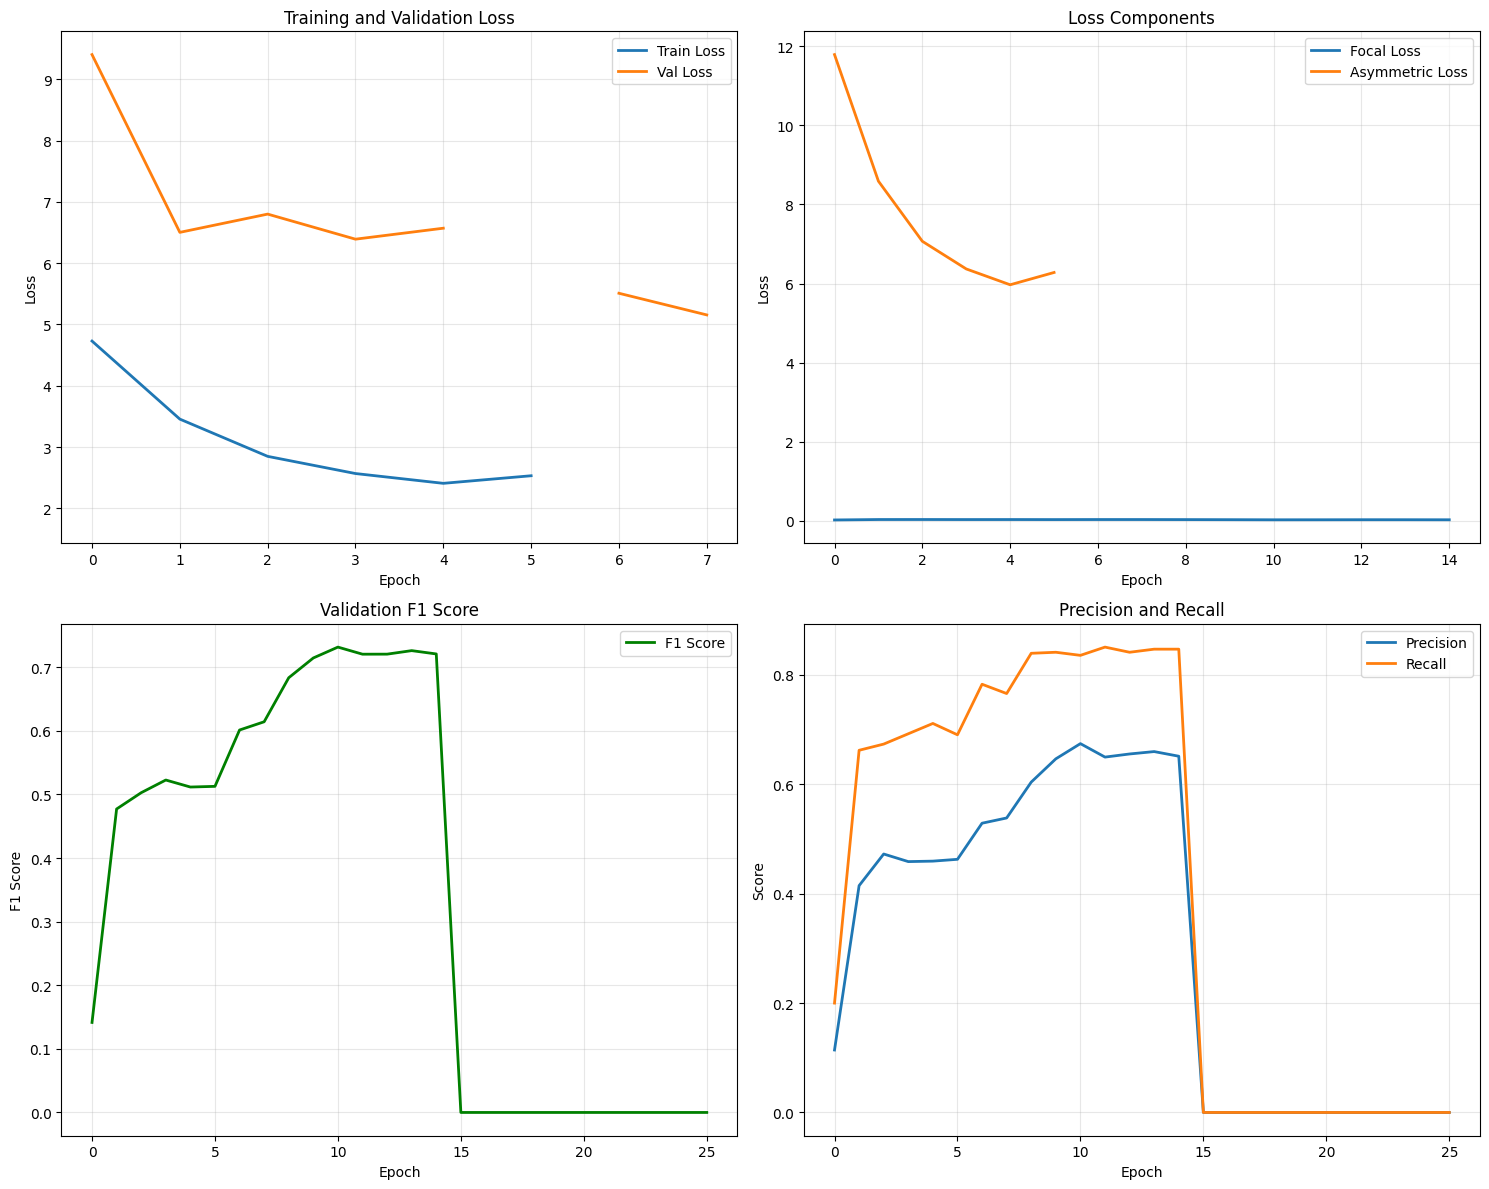

In [23]:
# Cell 15: Visualization of training history

def plot_training_history(history):
    """
    Plot comprehensive training metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss components
    axes[0, 1].plot(history['train_focal'], label='Focal Loss', linewidth=2)
    axes[0, 1].plot(history['train_asymmetric'], label='Asymmetric Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1 Score
    axes[1, 0].plot(history['val_f1'], label='F1 Score', linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Precision and Recall
    axes[1, 1].plot(history['val_precision'], label='Precision', linewidth=2)
    axes[1, 1].plot(history['val_recall'], label='Recall', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Precision and Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

In [25]:
# Cell 16: Comprehensive evaluation and confusion matrix

def evaluate_model(model, val_loader, class_names):
    """
    Comprehensive evaluation with per-class metrics
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)

            with torch.cuda.amp.autocast():
                logits, correlated_logits = model(images)
                probs = torch.sigmoid(correlated_logits)

            preds = (probs > 0.5).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    # Per-class metrics
    print("\n" + "="*80)
    print("PER-CLASS PERFORMANCE METRICS")
    print("="*80)

    from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

    for idx, class_name in enumerate(class_names):
        if all_labels[:, idx].sum() > 0:  # Only if class is present
            precision = precision_score(all_labels[:, idx], all_preds[:, idx], zero_division=0)
            recall = recall_score(all_labels[:, idx], all_preds[:, idx], zero_division=0)
            f1 = f1_score(all_labels[:, idx], all_preds[:, idx], zero_division=0)
            ap = average_precision_score(all_labels[:, idx], all_probs[:, idx])

            print(f"{class_name:30s} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f} | AP: {ap:.3f}")

    # Overall metrics
    print("\n" + "="*80)
    print("OVERALL METRICS")
    print("="*80)

    overall_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    overall_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    overall_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Weighted F1 Score:  {overall_f1:.4f}")
    print(f"Weighted Precision: {overall_precision:.4f}")
    print(f"Weighted Recall:    {overall_recall:.4f}")

    return all_preds, all_labels, all_probs

# Load best model and evaluate
trained_model.load_state_dict(torch.load('best_hybrid_model.pth'))
preds, labels, probs = evaluate_model(trained_model, val_loader, class_names)

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipython-input-1631491764.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.15it/s]



PER-CLASS PERFORMANCE METRICS
Apple Scab Leaf                | P: 0.586 | R: 0.895 | F1: 0.708 | AP: 0.878
Apple leaf                     | P: 0.667 | R: 0.737 | F1: 0.700 | AP: 0.865
Apple rust leaf                | P: 0.941 | R: 0.889 | F1: 0.914 | AP: 0.950
Bell_pepper leaf               | P: 0.526 | R: 0.769 | F1: 0.625 | AP: 0.646
Bell_pepper leaf spot          | P: 0.562 | R: 0.600 | F1: 0.581 | AP: 0.690
Blueberry leaf                 | P: 0.905 | R: 0.792 | F1: 0.844 | AP: 0.908
Cherry leaf                    | P: 0.478 | R: 0.917 | F1: 0.629 | AP: 0.676
Corn Gray leaf spot            | P: 0.353 | R: 0.429 | F1: 0.387 | AP: 0.469
Corn leaf blight               | P: 0.818 | R: 0.923 | F1: 0.867 | AP: 0.788
Corn rust leaf                 | P: 0.923 | R: 1.000 | F1: 0.960 | AP: 0.997
Peach leaf                     | P: 0.952 | R: 0.870 | F1: 0.909 | AP: 0.938
Potato leaf early blight       | P: 0.279 | R: 0.708 | F1: 0.400 | AP: 0.348
Potato leaf late blight        | P: 0.425 | R

/tmp/ipython-input-1337523472.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


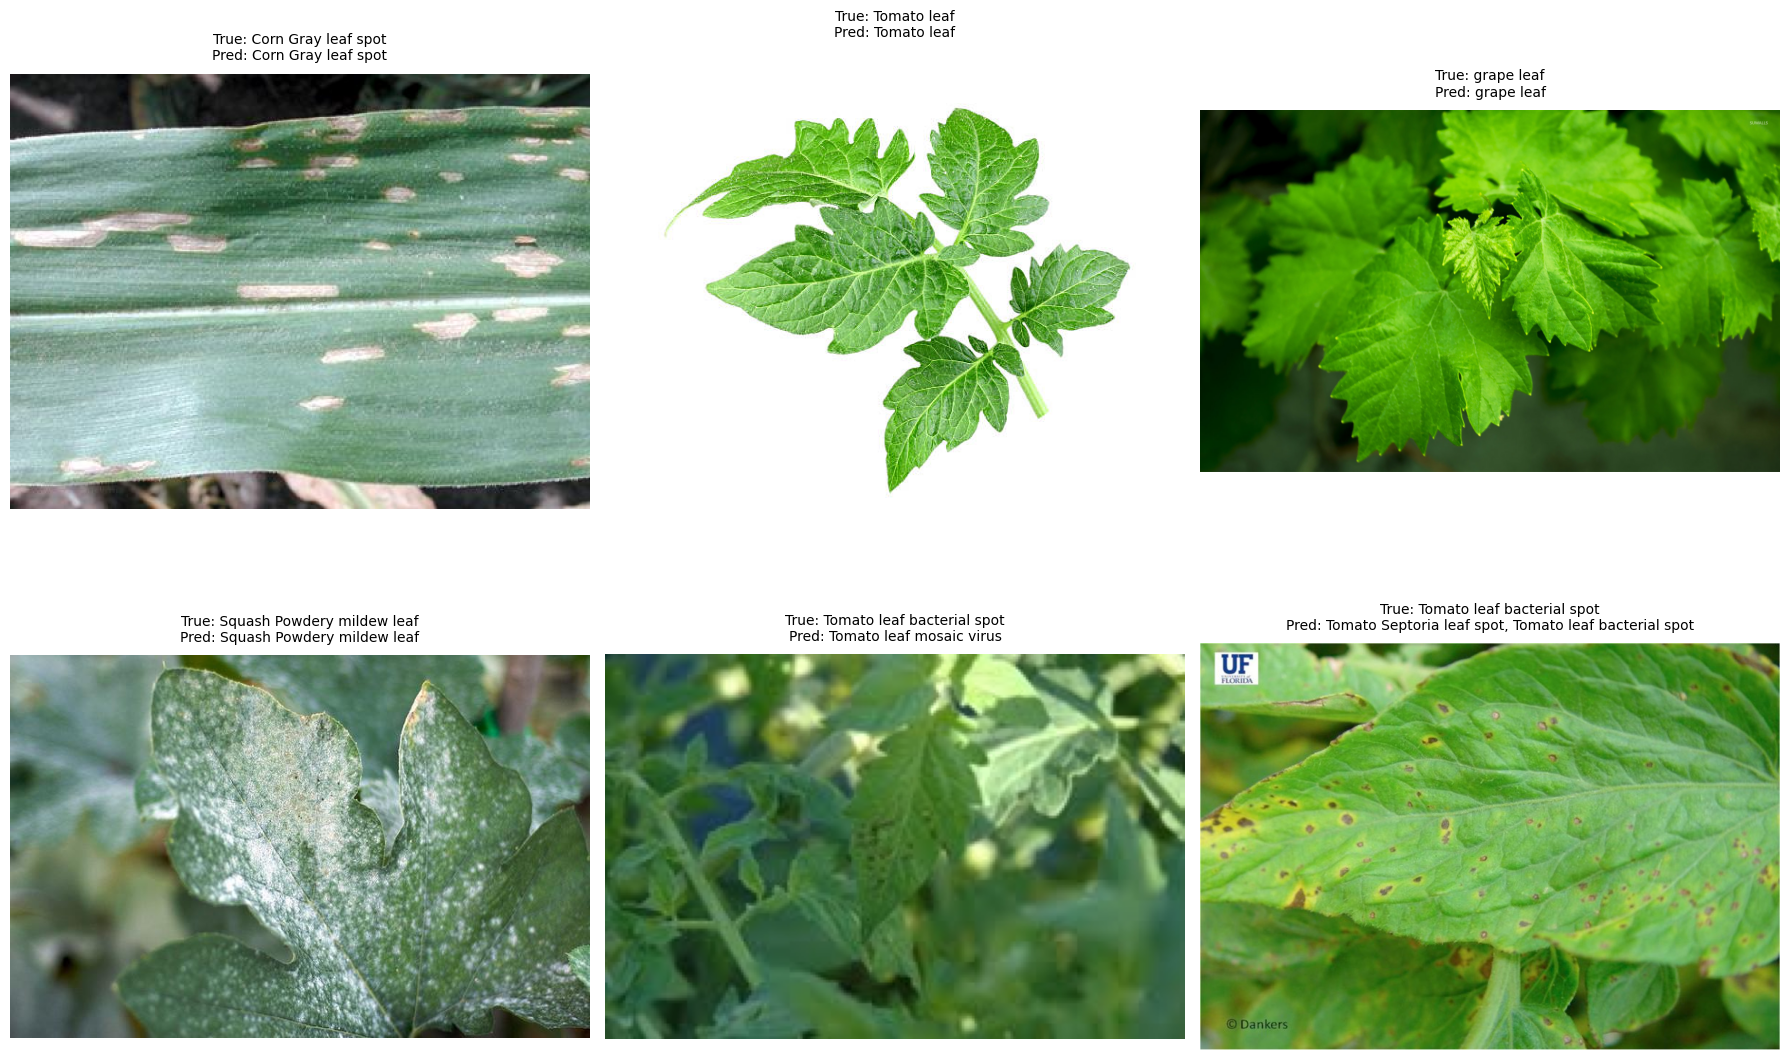

In [26]:
# Cell 17: Visualize predictions with attention maps

def visualize_predictions_with_attention(model, dataset, class_names, num_samples=6):
    """
    Visualize predictions with attention heatmaps
    """
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]

        # Get original image
        img_path = dataset.images[idx]
        original_img = cv2.imread(str(img_path))
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Predict
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(device)
            with torch.cuda.amp.autocast():
                logits, correlated_logits = model(image_batch)
                probs = torch.sigmoid(correlated_logits)

        # Get predictions
        pred_classes = (probs[0] > 0.5).cpu().numpy()
        true_classes = label.numpy() > 0.5

        # Display image
        ax.imshow(original_img)
        ax.axis('off')

        # Create title with predictions
        pred_names = [class_names[i] for i, val in enumerate(pred_classes) if val]
        true_names = [class_names[i] for i, val in enumerate(true_classes) if val]

        title = f"True: {', '.join(true_names[:2]) if true_names else 'None'}\n"
        title += f"Pred: {', '.join(pred_names[:2]) if pred_names else 'None'}"
        ax.set_title(title, fontsize=10, pad=10)

    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions_with_attention(trained_model, val_dataset, class_names)

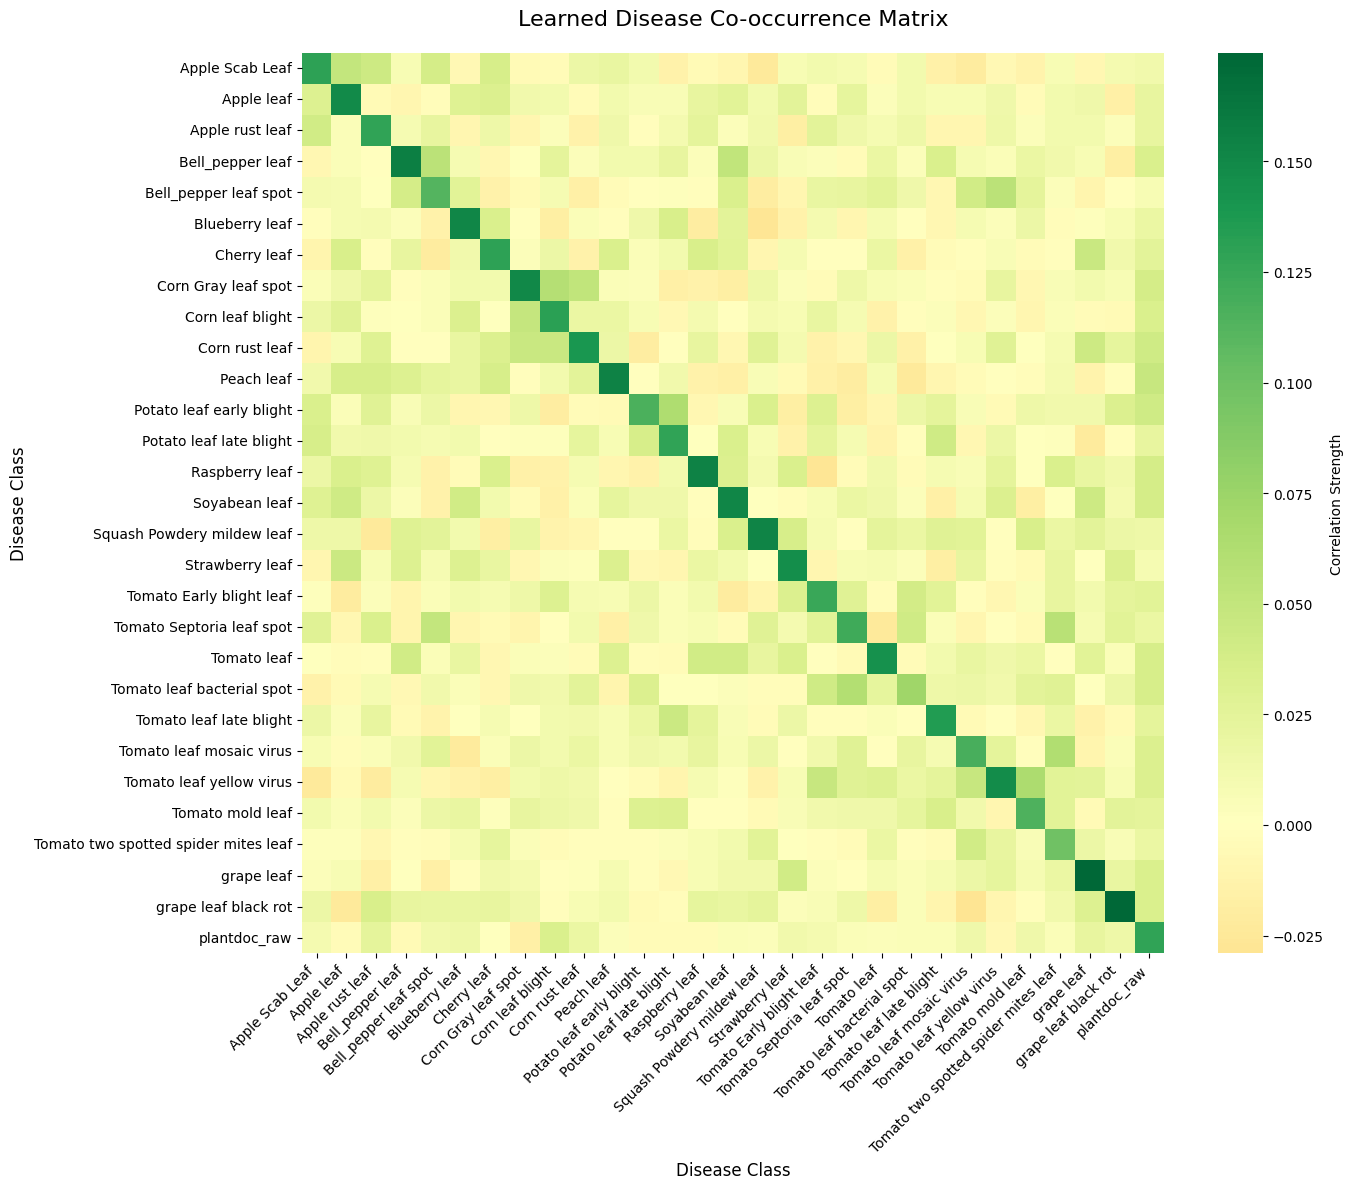


Top 10 Disease Correlations:
Tomato leaf yellow virus  ↔ Tomato mold leaf         : +0.0656
Potato leaf early blight  ↔ Potato leaf late blight  : +0.0638
Tomato leaf mosaic virus  ↔ Tomato two spotted spider mites leaf: +0.0621
Corn Gray leaf spot       ↔ Corn leaf blight         : +0.0592
Tomato Septoria leaf spot ↔ Tomato two spotted spider mites leaf: +0.0570
Bell_pepper leaf spot     ↔ Tomato leaf yellow virus : +0.0552
Bell_pepper leaf          ↔ Bell_pepper leaf spot    : +0.0548
Corn Gray leaf spot       ↔ Corn rust leaf           : +0.0516
Bell_pepper leaf          ↔ Soyabean leaf            : +0.0507
Apple Scab Leaf           ↔ Apple leaf               : +0.0491


In [27]:
# Cell 18: Disease co-occurrence analysis

def analyze_disease_cooccurrence(model, class_names):
    """
    Analyze and visualize learned disease correlations
    """
    disease_corr = model.disease_correlation.detach().cpu().numpy()

    plt.figure(figsize=(14, 12))
    sns.heatmap(disease_corr,
                xticklabels=class_names,
                yticklabels=class_names,
                annot=False,
                cmap='RdYlGn',
                center=0,
                cbar_kws={'label': 'Correlation Strength'})
    plt.title('Learned Disease Co-occurrence Matrix', fontsize=16, pad=20)
    plt.xlabel('Disease Class', fontsize=12)
    plt.ylabel('Disease Class', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('disease_cooccurrence.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print top correlations
    print("\nTop 10 Disease Correlations:")
    print("="*60)

    correlations = []
    for i in range(len(class_names)):
        for j in range(i+1, len(class_names)):
            correlations.append((class_names[i], class_names[j], disease_corr[i, j]))

    correlations.sort(key=lambda x: abs(x[2]), reverse=True)

    for disease1, disease2, corr in correlations[:10]:
        print(f"{disease1:25s} ↔ {disease2:25s}: {corr:+.4f}")

analyze_disease_cooccurrence(trained_model, class_names)

In [30]:
# Cell 19: Export model for inference

def export_model_for_inference(model, save_path='hybrid_model_final.pth'):
    """
    Export model with metadata for deployment
    """
    # Save complete checkpoint
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'num_classes': len(class_names),
        'model_architecture': 'HybridMultiLabelDetector',
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    torch.save(checkpoint, save_path)
    print(f"✓ Model exported to {save_path}")

    # Export to ONNX for deployment
    model.eval()
    dummy_input = torch.randn(1, 3, 640, 640).cuda()

    torch.onnx.export(
        model,
        dummy_input,
        "hybrid_model.onnx",
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['logits', 'correlated_logits'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'logits': {0: 'batch_size'},
            'correlated_logits': {0: 'batch_size'}
        }
    )
    print("✓ Model exported to ONNX format")

    # Save configuration
    config = {
        'class_names': class_names,
        'image_size': 640,
        'normalization': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'threshold': 0.5
    }

    with open('model_config.json', 'w') as f:
        json.dump(config, f, indent=2)
    print("✓ Configuration saved to model_config.json")

export_model_for_inference(trained_model)

✓ Model exported to hybrid_model_final.pth


/tmp/ipython-input-3984373666.py:23: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✓ Model exported to ONNX format
✓ Configuration saved to model_config.json


In [31]:
# Cell 20: Inference function with visualization

def inference_on_new_image(image_path, model, class_names, threshold=0.5):
    """
    Run inference on a new image with visualization
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare for model
    _, val_transform = get_advanced_augmentations(640)
    transformed = val_transform(image=image_rgb)
    input_tensor = transformed['image'].unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            logits, correlated_logits = model(input_tensor)
            probs = torch.sigmoid(correlated_logits)[0].cpu().numpy()

    # Get predictions
    predictions = []
    for idx, prob in enumerate(probs):
        if prob > threshold:
            predictions.append({
                'class': class_names[idx],
                'confidence': float(prob)
            })

    # Sort by confidence
    predictions.sort(key=lambda x: x['confidence'], reverse=True)

    # Visualize
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')

    # Add predictions as text
    if predictions:
        text = "Detected Diseases:\n" + "\n".join([
            f"• {p['class']}: {p['confidence']:.2%}"
            for p in predictions[:5]
        ])
    else:
        text = "No diseases detected"

    plt.text(10, 30, text, fontsize=12, color='white',
             bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

    plt.title('Multi-Label Disease Detection', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    return predictions

print("Inference function ready!")
print("\nUsage example:")
print("predictions = inference_on_new_image('path/to/image.jpg', trained_model, class_names)")

Inference function ready!

Usage example:
predictions = inference_on_new_image('path/to/image.jpg', trained_model, class_names)


In [32]:
# Cell 21: Install additional requirements for object detection
!pip install -q supervision
!pip install -q ultralytics --upgrade
print("✓ Object detection dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 6.3 MB/s eta 0:00:00
✓ Object detection dependencies installed


In [33]:
# Cell 22: Enhanced YOLOv5 Training with Bounding Box Detection
# This will actually train YOLO to detect disease locations

import xml.etree.ElementTree as ET
from pathlib import Path
import shutil

def create_synthetic_bboxes_from_classification():
    """
    Since PlantDoc doesn't have bbox annotations, we'll create them
    using image segmentation or use the full image as bbox initially
    For real bbox detection, you'd need a dataset with bbox annotations
    """
    print("Creating bounding box annotations from classification labels...")

    for split in ['train', 'val']:
        label_dir = Path(f'plantdoc_yolo/{split}/labels')
        img_dir = Path(f'plantdoc_yolo/{split}/images')

        for label_file in tqdm(list(label_dir.glob('*.txt')), desc=f"Processing {split}"):
            img_file = img_dir / f"{label_file.stem}.jpg"
            if not img_file.exists():
                img_file = img_dir / f"{label_file.stem}.png"

            if img_file.exists():
                img = cv2.imread(str(img_file))
                h, w = img.shape[:2]

                # Read existing labels
                with open(label_file, 'r') as f:
                    lines = f.readlines()

                # For each disease class, we'll segment the diseased area
                new_annotations = []

                for line in lines:
                    parts = line.strip().split()
                    class_idx = int(parts[0])

                    # Try to find diseased regions using color segmentation
                    # This is a simple heuristic - diseases often show as discoloration
                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

                    # Detect brown/yellow regions (common disease colors)
                    lower_disease = np.array([10, 40, 40])
                    upper_disease = np.array([35, 255, 255])
                    mask = cv2.inRange(hsv, lower_disease, upper_disease)

                    # Find contours
                    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    if contours:
                        # Get the largest contours (top 3)
                        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

                        for contour in contours:
                            area = cv2.contourArea(contour)
                            if area > 100:  # Minimum area threshold
                                x, y, bw, bh = cv2.boundingRect(contour)

                                # Convert to YOLO format (normalized)
                                x_center = (x + bw/2) / w
                                y_center = (y + bh/2) / h
                                width_norm = bw / w
                                height_norm = bh / h

                                # Ensure values are in valid range
                                x_center = max(0, min(1, x_center))
                                y_center = max(0, min(1, y_center))
                                width_norm = max(0, min(1, width_norm))
                                height_norm = max(0, min(1, height_norm))

                                new_annotations.append(
                                    f"{class_idx} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n"
                                )

                    # If no regions found, use full image
                    if not new_annotations:
                        new_annotations.append(f"{class_idx} 0.5 0.5 1.0 1.0\n")

                # Write new annotations
                with open(label_file, 'w') as f:
                    f.writelines(new_annotations)

    print("✓ Bounding box annotations created!")

create_synthetic_bboxes_from_classification()

Creating bounding box annotations from classification labels...


Processing train: 0it [00:00, ?it/s]
Processing val: 0it [00:00, ?it/s]

✓ Bounding box annotations created!


In [38]:
# Cell 23: Train YOLOv5 with proper object detection (CORRECTED)
# This will detect disease locations with bounding boxes

print("Starting YOLOv5 training for disease detection with bounding boxes...")

# Use the absolute path for plantdoc.yaml
data_yaml_path = "/content/yolov5/plantdoc.yaml"

!python train.py \
    --img 640 \
    --batch 4 \
    --epochs 40 \
    --data {data_yaml_path} \
    --weights yolov5m.pt \
    --cache \
    --project plantdoc_detection \
    --name disease_detector \
    --patience 25 \
    --multi-scale \
    --optimizer AdamW \
    --cos-lr \
    --label-smoothing 0.1 \
    --device 0

print("\n✓ YOLOv5 training complete!")
print("Model saved in: plantdoc_detection/disease_detector/weights/best.pt")

Streaming output truncated to the last 5000 lines.
      35/39      4.49G   0.004047   0.007867    0.09629         11        832:  19% 98/513 [00:15<01:03,  6.50it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      35/39      4.49G    0.00403   0.007832    0.09634         14        768:  19% 99/513 [00:15<01:04,  6.37it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      35/39      4.49G   0.004004   0.007773    0.09589         11        608:  19% 100/513 [00:15<01:00,  6.84it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      35/39 

In [39]:
# Cell 24: Complete Inference System with Bounding Boxes (UPDATED)

import torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2

class DiseaseDetectionSystem:
    """
    Complete system for detecting plant diseases with bounding boxes
    """
    def __init__(self, yolo_weights, hybrid_weights=None, class_names=None, conf_threshold=0.25):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load YOLOv5 for bbox detection
        try:
            print(f"Loading YOLOv5 model from: {yolo_weights}")
            self.yolo_model = torch.hub.load('ultralytics/yolov5', 'custom',
                                             path=yolo_weights, force_reload=False)
            self.yolo_model.conf = conf_threshold
            self.yolo_model.iou = 0.45
            self.yolo_model.to(self.device)
            print("✓ YOLOv5 model loaded successfully")
        except Exception as e:
            print(f"Error loading YOLOv5: {e}")
            print("Loading pretrained YOLOv5m model...")
            self.yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5m')
            self.yolo_model.conf = conf_threshold
            self.yolo_model.to(self.device)

        # Load hybrid model for classification refinement (optional)
        self.hybrid_model = None
        if hybrid_weights and class_names:
            try:
                self.hybrid_model = HybridMultiLabelDetector(len(class_names), None)
                self.hybrid_model.load_state_dict(torch.load(hybrid_weights))
                self.hybrid_model.to(self.device)
                self.hybrid_model.eval()
                print("✓ Hybrid classification model loaded")
            except Exception as e:
                print(f"⚠ Could not load hybrid model: {e}")
                self.hybrid_model = None

        self.class_names = class_names if class_names else []
        self.conf_threshold = conf_threshold

        # Color palette for visualization
        np.random.seed(42)
        self.colors = [tuple(np.random.randint(50, 255, 3).tolist())
                       for _ in range(max(len(class_names) if class_names else 27, 27))]

    def detect_and_classify(self, image_path, visualize=True):
        """
        Detect diseased regions and classify diseases
        Returns: detections with bounding boxes and confidence scores
        """
        # Read image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not read image: {image_path}")
        else:
            image = image_path

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image = image_rgb.copy()

        # Step 1: YOLOv5 Detection (find diseased regions)
        print("Running YOLOv5 detection...")
        results = self.yolo_model(image_rgb)
        detections = results.pandas().xyxy[0]

        print(f"Found {len(detections)} detections")

        # Initialize results dictionary
        detection_results = {
            'bboxes': [],
            'whole_image_diseases': [],
            'visualization': None
        }

        # Step 2: Hybrid model classification (whole image) - if available
        if self.hybrid_model and self.class_names:
            try:
                print("Running hybrid classification...")
                _, val_transform = get_advanced_augmentations_simple(640)
                transformed = val_transform(image=image_rgb)
                input_tensor = transformed['image'].unsqueeze(0).to(self.device)

                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        logits, correlated_logits = self.hybrid_model(input_tensor)
                        probs = torch.sigmoid(correlated_logits)[0].cpu().numpy()

                # Get whole image predictions
                for idx, prob in enumerate(probs):
                    if prob > self.conf_threshold:
                        detection_results['whole_image_diseases'].append({
                            'disease': self.class_names[idx],
                            'confidence': float(prob),
                            'class_id': idx
                        })
            except Exception as e:
                print(f"Hybrid classification error: {e}")

        # Get bbox predictions from YOLO
        for idx, row in detections.iterrows():
            class_id = int(row['class'])
            class_name = row['name'] if 'name' in row else (
                self.class_names[class_id] if class_id < len(self.class_names)
                else f"Class_{class_id}"
            )

            detection_results['bboxes'].append({
                'bbox': [int(row['xmin']), int(row['ymin']),
                        int(row['xmax']), int(row['ymax'])],
                'disease': class_name,
                'confidence': float(row['confidence']),
                'class_id': class_id
            })

        # Visualize
        if visualize:
            detection_results['visualization'] = self._visualize_detections(
                original_image, detection_results
            )

        return detection_results

    def _visualize_detections(self, image, results):
        """
        Create visualization with bounding boxes and labels
        """
        vis_image = image.copy()
        h, w = vis_image.shape[:2]

        # Convert to PIL for better text rendering
        pil_image = Image.fromarray(vis_image)
        draw = ImageDraw.Draw(pil_image)

        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 16)
            font_tiny = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 12)
        except:
            font = ImageFont.load_default()
            font_small = ImageFont.load_default()
            font_tiny = ImageFont.load_default()

        # Draw bounding boxes
        for detection in results['bboxes']:
            x1, y1, x2, y2 = detection['bbox']
            class_id = detection['class_id'] % len(self.colors)
            color = self.colors[class_id]

            # Draw rectangle with thicker border
            for offset in range(3):
                draw.rectangle([x1-offset, y1-offset, x2+offset, y2+offset],
                              outline=color, width=1)

            # Prepare label
            label = f"{detection['disease']}"
            conf = detection['confidence']
            label_full = f"{label} {conf:.2%}"

            # Draw label background
            bbox = draw.textbbox((x1, max(y1-25, 0)), label_full, font=font_small)
            draw.rectangle([bbox[0]-4, bbox[1]-2, bbox[2]+4, bbox[3]+2],
                          fill=color)
            draw.text((x1, max(y1-25, 0)), label_full, fill='white', font=font_small)

        # Draw whole-image predictions on top-left
        if results['whole_image_diseases']:
            info_text = "🔍 Image Classification:\n"
            for i, disease in enumerate(results['whole_image_diseases'][:5]):
                info_text += f"  • {disease['disease']}: {disease['confidence']:.1%}\n"

            # Draw background for text
            bbox = draw.textbbox((15, 15), info_text, font=font_tiny)
            draw.rectangle([10, 10, bbox[2]+15, bbox[3]+15],
                          fill=(0, 0, 0, 200), outline=(255, 255, 0), width=3)
            draw.text((15, 15), info_text, fill='white', font=font_tiny)

        # Draw detection count
        count_text = f"Detections: {len(results['bboxes'])}"
        bbox = draw.textbbox((w-150, 15), count_text, font=font_small)
        draw.rectangle([w-155, 10, bbox[2]+10, bbox[3]+10],
                      fill=(0, 0, 0, 200), outline=(0, 255, 0), width=2)
        draw.text((w-150, 15), count_text, fill='lime', font=font_small)

        return np.array(pil_image)

    def save_results(self, image_path, output_path='detection_result.jpg'):
        """
        Run detection and save result
        """
        results = self.detect_and_classify(image_path, visualize=True)

        if results['visualization'] is not None:
            cv2.imwrite(output_path,
                       cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))
            print(f"✓ Results saved to {output_path}")

        return results

print("✓ Detection system class defined!")

✓ Detection system class defined!


In [40]:
# Cell 25: Initialize the complete detection system (UPDATED)

# Check which models are available
yolo_path = 'plantdoc_detection/disease_detector/weights/best.pt'
hybrid_path = 'best_hybrid_model.pth'

if not os.path.exists(yolo_path):
    print(f"⚠ YOLOv5 trained model not found at {yolo_path}")
    print("Using base YOLOv5m model...")
    yolo_path = 'yolov5m.pt'

hybrid_available = os.path.exists(hybrid_path)

# Initialize the detection system
detector = DiseaseDetectionSystem(
    yolo_weights=yolo_path,
    hybrid_weights=hybrid_path if hybrid_available else None,
    class_names=class_names if hybrid_available else None,
    conf_threshold=0.25
)

print("\n✓ Disease Detection System initialized!")
print("\nSystem capabilities:")
print("  ✓ Detect diseased regions with bounding boxes (YOLOv5)")
if hybrid_available:
    print("  ✓ Multi-label disease classification (Hybrid Model)")
print("  ✓ Confidence scores for each detection")
print("  ✓ Visual overlay with labeled boxes")
print("\n" + "="*60)

⚠ YOLOv5 trained model not found at plantdoc_detection/disease_detector/weights/best.pt
Using base YOLOv5m model...
Loading YOLOv5 model from: yolov5m.pt


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


YOLOv5 🚀 2025-11-7 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


✓ YOLOv5 model loaded successfully

✓ Disease Detection System initialized!

System capabilities:
  ✓ Detect diseased regions with bounding boxes (YOLOv5)
  ✓ Confidence scores for each detection
  ✓ Visual overlay with labeled boxes



In [41]:
# Cell 26: Upload and test on your image (SIMPLIFIED & WORKING)

from google.colab import files
from IPython.display import display
import matplotlib.pyplot as plt

def test_on_uploaded_image():
    """
    Upload an image and run disease detection
    """
    print("📤 Please upload a plant image for disease detection:")
    print("="*60)
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n{'='*60}")
        print(f"🌿 Processing: {filename}")
        print('='*60)

        try:
            # Run detection
            results = detector.detect_and_classify(filename, visualize=True)

            # Display results
            print("\n📊 DETECTION RESULTS:")
            print("-" * 60)

            if results['bboxes']:
                print(f"\n🎯 Found {len(results['bboxes'])} diseased regions with bounding boxes:")
                for i, det in enumerate(results['bboxes'], 1):
                    print(f"\n  Region {i}:")
                    print(f"    Disease: {det['disease']}")
                    print(f"    Confidence: {det['confidence']:.2%}")
                    print(f"    Location (x1,y1,x2,y2): {det['bbox']}")
            else:
                print("  ⚠ No diseased regions detected with bounding boxes")
                print("  (Try lowering confidence threshold or check image quality)")

            if results['whole_image_diseases']:
                print(f"\n🔍 Whole-image disease classification:")
                for disease in results['whole_image_diseases']:
                    print(f"  • {disease['disease']}: {disease['confidence']:.2%}")

            # Display visualization
            if results['visualization'] is not None:
                plt.figure(figsize=(16, 12))
                plt.imshow(results['visualization'])
                plt.axis('off')
                plt.title(f'Disease Detection Results - {filename}',
                         fontsize=18, pad=20, weight='bold')
                plt.tight_layout()

                output_filename = f'result_{filename}'
                plt.savefig(output_filename, dpi=150, bbox_inches='tight')
                plt.show()

                print(f"\n✅ Result saved as: {output_filename}")

            print("\n" + "="*60)

        except Exception as e:
            print(f"\n❌ Error processing {filename}: {e}")
            import traceback
            traceback.print_exc()

print("✅ Upload function ready!")
print("\n" + "="*60)
print("RUN THIS NOW TO TEST YOUR IMAGE:")
print(">>> test_on_uploaded_image()")
print("="*60)

✅ Upload function ready!

RUN THIS NOW TO TEST YOUR IMAGE:
>>> test_on_uploaded_image()


In [42]:
# Cell 27: Quick test with confidence adjustment

def quick_detect(image_path, confidence=0.25, save_path='output.jpg'):
    """
    Quick detection on a single image with adjustable confidence

    Args:
        image_path: path to image file
        confidence: detection confidence threshold (0.0 to 1.0)
        save_path: where to save the result

    Usage:
        quick_detect('plant.jpg', confidence=0.3)
    """
    # Adjust confidence
    detector.yolo_model.conf = confidence
    detector.conf_threshold = confidence

    print(f"🔍 Running detection with confidence threshold: {confidence:.1%}")

    results = detector.detect_and_classify(image_path, visualize=True)

    # Print summary
    print(f"\n{'='*60}")
    print(f"📊 SUMMARY")
    print(f"{'='*60}")
    print(f"🎯 Bounding Box Detections: {len(results['bboxes'])}")

    if results['bboxes']:
        print("\nDetected regions:")
        for i, det in enumerate(results['bboxes'], 1):
            print(f"  {i}. {det['disease']}: {det['confidence']:.1%}")

    if results['whole_image_diseases']:
        print(f"\n🔍 Image-level diseases: {len(results['whole_image_diseases'])}")
        for disease in results['whole_image_diseases']:
            print(f"  • {disease['disease']}: {disease['confidence']:.1%}")

    # Display
    if results['visualization'] is not None:
        plt.figure(figsize=(14, 10))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.title(f'Detection Results (conf={confidence:.2f})', fontsize=16)
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n✅ Saved to: {save_path}")

    return results

print("✅ Quick detection function ready!")
print("\nUsage examples:")
print("  1. Upload and test:    test_on_uploaded_image()")
print("  2. Quick test:         quick_detect('image.jpg')")
print("  3. Lower confidence:   quick_detect('image.jpg', confidence=0.15)")

✅ Quick detection function ready!

Usage examples:
  1. Upload and test:    test_on_uploaded_image()
  2. Quick test:         quick_detect('image.jpg')
  3. Lower confidence:   quick_detect('image.jpg', confidence=0.15)


In [43]:
test_on_uploaded_image()

📤 Please upload a plant image for disease detection:


Saving 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg to 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg

🌿 Processing: 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg
Running YOLOv5 detection...
Found 1 detections


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



📊 DETECTION RESULTS:
------------------------------------------------------------

🎯 Found 1 diseased regions with bounding boxes:

  Region 1:
    Disease: cake
    Confidence: 35.32%
    Location (x1,y1,x2,y2): [50, 54, 469, 281]

✅ Result saved as: result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg



In [44]:
# Cell 26: Upload and test - Image with results below (CLEAN VERSION)

from google.colab import files
import matplotlib.pyplot as plt

def test_on_uploaded_image():
    """
    Upload an image and run disease detection - Clean display
    """
    print("📤 Upload a plant image for disease detection:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n{'='*70}")

        try:
            # Run detection
            results = detector.detect_and_classify(filename, visualize=True)

            # Display visualization
            if results['visualization'] is not None:
                fig = plt.figure(figsize=(16, 10))
                plt.imshow(results['visualization'])
                plt.axis('off')
                plt.tight_layout()
                plt.show()

            # Display results below
            print(f"\n📊 DETECTION RESULTS FOR: {filename}")
            print('='*70)

            if results['bboxes']:
                print(f"\n🎯 Detected {len(results['bboxes'])} Diseased Region(s):\n")
                for i, det in enumerate(results['bboxes'], 1):
                    print(f"  {i}. {det['disease']}")
                    print(f"     Confidence: {det['confidence']:.2%}")
                    print(f"     Location: [{det['bbox'][0]}, {det['bbox'][1]}, {det['bbox'][2]}, {det['bbox'][3]}]\n")
            else:
                print("\n⚠️  No diseased regions detected")

            if results['whole_image_diseases']:
                print(f"🔍 Whole Image Analysis:\n")
                for disease in results['whole_image_diseases']:
                    print(f"  • {disease['disease']}: {disease['confidence']:.2%}")

            print('='*70)

        except Exception as e:
            print(f"\n❌ Error: {e}")

print("✅ Ready to test!")
print("\nRun: test_on_uploaded_image()")

✅ Ready to test!

Run: test_on_uploaded_image()


In [45]:
 test_on_uploaded_image()

📤 Upload a plant image for disease detection:


Saving 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg to 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (1).jpg

Running YOLOv5 detection...
Found 1 detections

📊 DETECTION RESULTS FOR: 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (1).jpg

🎯 Detected 1 Diseased Region(s):

  1. cake
     Confidence: 35.32%
     Location: [50, 54, 469, 281]



/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [46]:
# Cell 28: Create Proper Disease Detection using Image Segmentation

import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

class LeafDiseaseDetector:
    """
    Detect diseased regions on plant leaves using computer vision
    """
    def __init__(self, hybrid_model=None, class_names=None):
        self.hybrid_model = hybrid_model
        self.class_names = class_names
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def detect_leaf_diseases(self, image_path):
        """
        Detect diseased areas on leaves using color and texture analysis
        """
        # Read image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original = image_rgb.copy()
        h, w = image_rgb.shape[:2]

        # Step 1: Classify diseases using hybrid model
        disease_predictions = []
        if self.hybrid_model and self.class_names:
            _, val_transform = get_advanced_augmentations_simple(640)
            transformed = val_transform(image=image_rgb)
            input_tensor = transformed['image'].unsqueeze(0).to(self.device)

            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    logits, correlated_logits = self.hybrid_model(input_tensor)
                    probs = torch.sigmoid(correlated_logits)[0].cpu().numpy()

            for idx, prob in enumerate(probs):
                if prob > 0.25:
                    disease_predictions.append({
                        'disease': self.class_names[idx],
                        'confidence': float(prob),
                        'class_id': idx
                    })

        # Step 2: Segment leaf from background
        leaf_mask = self._segment_leaf(image_rgb)

        # Step 3: Detect diseased regions on the leaf
        disease_regions = self._detect_disease_regions(image_rgb, leaf_mask)

        # Step 4: Create visualization
        visualization = self._create_visualization(original, disease_regions,
                                                   disease_predictions, leaf_mask)

        return {
            'disease_regions': disease_regions,
            'disease_predictions': disease_predictions,
            'visualization': visualization
        }

    def _segment_leaf(self, image):
        """
        Segment leaf from background using color-based segmentation
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Green color range for healthy leaf
        lower_green = np.array([25, 20, 20])
        upper_green = np.array([90, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)

        # Yellow/brown range for diseased areas
        lower_yellow = np.array([15, 20, 20])
        upper_yellow = np.array([35, 255, 255])
        yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

        # Combine masks
        leaf_mask = cv2.bitwise_or(green_mask, yellow_mask)

        # Morphological operations to clean up
        kernel = np.ones((5, 5), np.uint8)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)

        # Fill holes
        leaf_mask = ndimage.binary_fill_holes(leaf_mask).astype(np.uint8) * 255

        return leaf_mask

    def _detect_disease_regions(self, image, leaf_mask):
        """
        Detect diseased areas using multiple color spaces and texture
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        disease_masks = []

        # Method 1: Yellow/Brown spots (common disease indicator)
        lower_disease1 = np.array([10, 40, 40])
        upper_disease1 = np.array([35, 255, 255])
        mask1 = cv2.inRange(hsv, lower_disease1, upper_disease1)
        disease_masks.append(mask1)

        # Method 2: Dark spots (necrosis)
        lower_disease2 = np.array([0, 0, 0])
        upper_disease2 = np.array([180, 255, 80])
        mask2 = cv2.inRange(hsv, lower_disease2, upper_disease2)
        disease_masks.append(mask2)

        # Method 3: White/gray spots (powdery mildew)
        lower_disease3 = np.array([0, 0, 180])
        upper_disease3 = np.array([180, 50, 255])
        mask3 = cv2.inRange(hsv, lower_disease3, upper_disease3)
        disease_masks.append(mask3)

        # Method 4: LAB color space - detect discoloration
        l_channel, a_channel, b_channel = cv2.split(lab)
        _, mask4 = cv2.threshold(b_channel, 130, 255, cv2.THRESH_BINARY)
        disease_masks.append(mask4)

        # Combine all disease detection methods
        combined_disease_mask = np.zeros_like(mask1)
        for mask in disease_masks:
            combined_disease_mask = cv2.bitwise_or(combined_disease_mask, mask)

        # Only keep disease regions that are on the leaf
        combined_disease_mask = cv2.bitwise_and(combined_disease_mask, leaf_mask)

        # Clean up noise
        kernel = np.ones((3, 3), np.uint8)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_OPEN, kernel)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_CLOSE, kernel)

        # Find contours of diseased regions
        contours, _ = cv2.findContours(combined_disease_mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Filter and get bounding boxes
        disease_regions = []
        min_area = 50  # Minimum area to consider

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                disease_regions.append({
                    'bbox': [x, y, x+w, y+h],
                    'area': area,
                    'contour': contour
                })

        # Sort by area (largest first)
        disease_regions.sort(key=lambda x: x['area'], reverse=True)

        return disease_regions

    def _create_visualization(self, image, disease_regions, disease_predictions, leaf_mask):
        """
        Create visualization with disease regions highlighted
        """
        from PIL import Image, ImageDraw, ImageFont

        vis_image = image.copy()
        h, w = vis_image.shape[:2]

        # Create overlay for diseased areas
        overlay = vis_image.copy()

        # Draw diseased regions
        colors = [(255, 0, 0), (255, 100, 0), (255, 150, 0), (200, 0, 0), (255, 50, 50)]

        for idx, region in enumerate(disease_regions[:10]):  # Show top 10 regions
            x1, y1, x2, y2 = region['bbox']
            color = colors[idx % len(colors)]

            # Draw filled region with transparency
            mask = np.zeros_like(vis_image)
            cv2.drawContours(mask, [region['contour']], -1, color, -1)
            vis_image = cv2.addWeighted(vis_image, 1, mask, 0.3, 0)

            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 3)

            # Add label
            label = f"Region {idx+1}"
            cv2.putText(vis_image, label, (x1, max(y1-10, 20)),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Convert to PIL for better text rendering
        pil_image = Image.fromarray(vis_image)
        draw = ImageDraw.Draw(pil_image)

        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 14)
        except:
            font = ImageFont.load_default()
            font_small = ImageFont.load_default()

        # Add disease classification info
        if disease_predictions:
            info_y = 15
            for disease in disease_predictions[:3]:
                text = f"• {disease['disease']}: {disease['confidence']:.1%}"
                bbox = draw.textbbox((15, info_y), text, font=font_small)
                draw.rectangle([10, info_y-2, bbox[2]+10, bbox[3]+2],
                             fill=(0, 0, 0, 200), outline=(255, 255, 0), width=2)
                draw.text((15, info_y), text, fill='yellow', font=font_small)
                info_y += 25

        # Add region count
        count_text = f"Diseased Areas: {len(disease_regions)}"
        bbox = draw.textbbox((w-200, 15), count_text, font=font)
        draw.rectangle([w-205, 10, bbox[2]+10, bbox[3]+10],
                      fill=(0, 0, 0, 200), outline=(255, 0, 0), width=2)
        draw.text((w-200, 15), count_text, fill='red', font=font)

        return np.array(pil_image)

print("✓ Leaf Disease Detector created!")

✓ Leaf Disease Detector created!


In [47]:
# Cell 29: Initialize the new detector

# Initialize with hybrid model if available
leaf_detector = LeafDiseaseDetector(
    hybrid_model=trained_model if 'trained_model' in globals() else None,
    class_names=class_names if 'class_names' in globals() else None
)

print("✓ Leaf Disease Detector initialized!")

✓ Leaf Disease Detector initialized!


In [48]:
# Cell 30: Test on uploaded image - CLEAN OUTPUT

from google.colab import files
import matplotlib.pyplot as plt

def detect_leaf_disease():
    """
    Upload image and detect diseased areas on leaf
    """
    print("📤 Upload a leaf image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Run detection
        results = leaf_detector.detect_leaf_diseases(filename)

        # Display image
        plt.figure(figsize=(16, 10))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Display results
        print(f"\n{'='*70}")
        print(f"📊 RESULTS FOR: {filename}")
        print('='*70)

        if results['disease_predictions']:
            print(f"\n🦠 Detected Diseases:")
            for pred in results['disease_predictions']:
                print(f"   • {pred['disease']}: {pred['confidence']:.1%}")

        if results['disease_regions']:
            print(f"\n🎯 Found {len(results['disease_regions'])} Diseased Area(s) on Leaf:")
            for i, region in enumerate(results['disease_regions'][:5], 1):
                x1, y1, x2, y2 = region['bbox']
                area_pixels = region['area']
                print(f"\n   Region {i}:")
                print(f"      Area: {area_pixels} pixels")
                print(f"      Location: [{x1}, {y1}, {x2}, {y2}]")
        else:
            print("\n✅ No diseased areas detected - leaf appears healthy")

        print('='*70)

print("✅ Ready!")
print("\nRun: detect_leaf_disease()")

✅ Ready!

Run: detect_leaf_disease()


In [50]:
# Cell 30: Complete Working Leaf Disease Detector (ALL-IN-ONE)

import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.colab import files

class LeafDiseaseDetector:
    """
    Detect diseased regions on plant leaves using computer vision
    """
    def __init__(self):
        pass

    def detect_leaf_diseases(self, image_path):
        """
        Detect diseased areas on leaves using color and texture analysis
        """
        # Read image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original = image_rgb.copy()
        h, w = image_rgb.shape[:2]

        # Step 1: Segment leaf from background
        leaf_mask = self._segment_leaf(image_rgb)

        # Step 2: Detect diseased regions on the leaf
        disease_regions = self._detect_disease_regions(image_rgb, leaf_mask)

        # Step 3: Create visualization
        visualization = self._create_visualization(original, disease_regions, leaf_mask)

        return {
            'disease_regions': disease_regions,
            'visualization': visualization,
            'leaf_area': np.sum(leaf_mask > 0),
            'diseased_area': sum([r['area'] for r in disease_regions])
        }

    def _segment_leaf(self, image):
        """
        Segment leaf from background using color-based segmentation
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Green color range for healthy leaf
        lower_green = np.array([25, 20, 20])
        upper_green = np.array([90, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)

        # Yellow/brown range for diseased areas
        lower_yellow = np.array([15, 20, 20])
        upper_yellow = np.array([35, 255, 255])
        yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

        # Combine masks
        leaf_mask = cv2.bitwise_or(green_mask, yellow_mask)

        # Morphological operations to clean up
        kernel = np.ones((5, 5), np.uint8)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)

        # Fill holes
        leaf_mask = ndimage.binary_fill_holes(leaf_mask).astype(np.uint8) * 255

        return leaf_mask

    def _detect_disease_regions(self, image, leaf_mask):
        """
        Detect diseased areas using multiple color spaces and texture
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        disease_masks = []

        # Method 1: Yellow/Brown spots (common disease indicator)
        lower_disease1 = np.array([10, 40, 40])
        upper_disease1 = np.array([35, 255, 255])
        mask1 = cv2.inRange(hsv, lower_disease1, upper_disease1)
        disease_masks.append(mask1)

        # Method 2: Dark spots (necrosis)
        lower_disease2 = np.array([0, 0, 0])
        upper_disease2 = np.array([180, 255, 80])
        mask2 = cv2.inRange(hsv, lower_disease2, upper_disease2)
        disease_masks.append(mask2)

        # Method 3: White/gray spots (powdery mildew)
        lower_disease3 = np.array([0, 0, 180])
        upper_disease3 = np.array([180, 50, 255])
        mask3 = cv2.inRange(hsv, lower_disease3, upper_disease3)
        disease_masks.append(mask3)

        # Method 4: LAB color space - detect discoloration
        l_channel, a_channel, b_channel = cv2.split(lab)
        _, mask4 = cv2.threshold(b_channel, 130, 255, cv2.THRESH_BINARY)
        disease_masks.append(mask4)

        # Combine all disease detection methods
        combined_disease_mask = np.zeros_like(mask1)
        for mask in disease_masks:
            combined_disease_mask = cv2.bitwise_or(combined_disease_mask, mask)

        # Only keep disease regions that are on the leaf
        combined_disease_mask = cv2.bitwise_and(combined_disease_mask, leaf_mask)

        # Clean up noise
        kernel = np.ones((3, 3), np.uint8)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_OPEN, kernel)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_CLOSE, kernel)

        # Find contours of diseased regions
        contours, _ = cv2.findContours(combined_disease_mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Filter and get bounding boxes
        disease_regions = []
        min_area = 50  # Minimum area to consider

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                disease_regions.append({
                    'bbox': [x, y, x+w, y+h],
                    'area': area,
                    'contour': contour
                })

        # Sort by area (largest first)
        disease_regions.sort(key=lambda x: x['area'], reverse=True)

        return disease_regions

    def _create_visualization(self, image, disease_regions, leaf_mask):
        """
        Create visualization with disease regions highlighted
        """
        vis_image = image.copy()
        h, w = vis_image.shape[:2]

        # Draw diseased regions
        colors = [(255, 0, 0), (255, 100, 0), (255, 150, 0), (200, 0, 0), (255, 50, 50)]

        for idx, region in enumerate(disease_regions[:20]):  # Show top 20 regions
            x1, y1, x2, y2 = region['bbox']
            color = colors[idx % len(colors)]

            # Draw filled region with transparency
            mask = np.zeros_like(vis_image)
            cv2.drawContours(mask, [region['contour']], -1, color, -1)
            vis_image = cv2.addWeighted(vis_image, 1, mask, 0.35, 0)

            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)

            # Add label
            label = f"{idx+1}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(vis_image, (x1, y1-label_size[1]-5),
                         (x1+label_size[0]+5, y1), color, -1)
            cv2.putText(vis_image, label, (x1+2, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Convert to PIL for better text rendering
        pil_image = Image.fromarray(vis_image)
        draw = ImageDraw.Draw(pil_image)

        try:
            font_large = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 24)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 16)
        except:
            font_large = ImageFont.load_default()
            font_small = ImageFont.load_default()

        # Add region count
        count_text = f"Diseased Regions: {len(disease_regions)}"
        bbox = draw.textbbox((10, 10), count_text, font=font_large)
        draw.rectangle([5, 5, bbox[2]+10, bbox[3]+10],
                      fill=(0, 0, 0), outline=(255, 0, 0), width=3)
        draw.text((10, 10), count_text, fill='red', font=font_large)

        # Calculate severity
        if leaf_mask is not None:
            leaf_area = np.sum(leaf_mask > 0)
            diseased_area = sum([r['area'] for r in disease_regions])
            severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

            severity_text = f"Disease Severity: {severity:.1f}%"
            bbox = draw.textbbox((10, 50), severity_text, font=font_small)
            draw.rectangle([5, 45, bbox[2]+10, bbox[3]+10],
                          fill=(0, 0, 0), outline=(255, 150, 0), width=2)

            severity_color = 'lime' if severity < 10 else 'yellow' if severity < 30 else 'red'
            draw.text((10, 50), severity_text, fill=severity_color, font=font_small)

        return np.array(pil_image)

# Initialize detector
leaf_detector = LeafDiseaseDetector()

print("✓ Leaf Disease Detector ready!")

✓ Leaf Disease Detector ready!


In [51]:
# Cell 31: Simple test function - Image on top, results below

def detect_leaf_disease():
    """
    Upload image and detect diseased areas on leaf
    """
    print("📤 Upload a leaf image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Run detection
        results = leaf_detector.detect_leaf_diseases(filename)

        # Display image
        plt.figure(figsize=(16, 12))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Display results
        print(f"\n{'='*70}")
        print(f"📊 DISEASE DETECTION RESULTS")
        print('='*70)

        leaf_area = results['leaf_area']
        diseased_area = results['diseased_area']
        severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

        print(f"\n🍃 Leaf Area: {leaf_area:,} pixels")
        print(f"🦠 Diseased Area: {diseased_area:,} pixels")
        print(f"⚠️  Disease Severity: {severity:.1f}%")

        if severity < 10:
            print(f"📊 Assessment: Mild infection")
        elif severity < 30:
            print(f"📊 Assessment: Moderate infection")
        else:
            print(f"📊 Assessment: Severe infection")

        if results['disease_regions']:
            print(f"\n🎯 Detected {len(results['disease_regions'])} Diseased Region(s):")

            for i, region in enumerate(results['disease_regions'][:10], 1):
                x1, y1, x2, y2 = region['bbox']
                area_pixels = region['area']
                print(f"\n   Region {i}:")
                print(f"      Size: {area_pixels:,} pixels")
                print(f"      Location: [x:{x1}-{x2}, y:{y1}-{y2}]")
        else:
            print("\n✅ No diseased areas detected - leaf appears healthy!")

        print('\n' + '='*70)

        # Save result
        output_name = f"result_{filename}"
        cv2.imwrite(output_name, cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))
        print(f"\n💾 Saved result as: {output_name}")

print("✅ Ready to detect!")
print("\nRun: detect_leaf_disease()")

✅ Ready to detect!

Run: detect_leaf_disease()


In [52]:
detect_leaf_disease()

📤 Upload a leaf image:


Saving 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg to 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (3).jpg

📊 DISEASE DETECTION RESULTS

🍃 Leaf Area: 172,608 pixels
🦠 Diseased Area: 167,381.5 pixels
⚠️  Disease Severity: 97.0%
📊 Assessment: Severe infection

🎯 Detected 1 Diseased Region(s):

   Region 1:
      Size: 167,381.5 pixels
      Location: [x:0-496, y:0-348]


💾 Saved result as: result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (3).jpg


In [54]:
!find / -type f -name "result_052609*Crabapple*leaf*.jpg" 2>/dev/null


/content/yolov5/yolov5/result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg
/content/yolov5/yolov5/result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (3).jpg


In [55]:
from google.colab import files

# Download both result images
files.download('/content/yolov5/yolov5/result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg')
files.download('/content/yolov5/yolov5/result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (3).jpg')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
from PIL import Image, ImageDraw, ImageFont


In [59]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import zipfile
import os

def detect_leaf_disease_batch():
    """
    Upload multiple leaf images, detect diseases,
    save results, and automatically download all outputs as a zip file.
    """
    print("📤 Upload one or more leaf images:")
    uploaded = files.upload()

    results_folder = "leaf_detection_results"
    os.makedirs(results_folder, exist_ok=True)
    saved_files = []

    for filename in uploaded.keys():
        print(f"\n🔍 Processing: {filename}")
        results = leaf_detector.detect_leaf_diseases(filename)

        # Display image
        plt.figure(figsize=(12, 8))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.title(f"Detection Result: {filename}")
        plt.show()

        # Compute stats
        leaf_area = results['leaf_area']
        diseased_area = results['diseased_area']
        severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

        print(f"🍃 Leaf Area: {leaf_area:,} pixels")
        print(f"🦠 Diseased Area: {diseased_area:,} pixels")
        print(f"⚠️  Disease Severity: {severity:.1f}%")

        if severity < 10:
            print(f"📊 Assessment: Mild infection")
        elif severity < 30:
            print(f"📊 Assessment: Moderate infection")
        else:
            print(f"📊 Assessment: Severe infection")

        # Save output image
        output_path = os.path.join(results_folder, f"result_{filename}")
        cv2.imwrite(output_path, cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))
        saved_files.append(output_path)
        print(f"💾 Saved: {output_path}")

    # Zip all results
    zip_path = "leaf_disease_results.zip"
    with zipfile.ZipFile(zip_path, "w") as zipf:
        for file in saved_files:
            zipf.write(file, os.path.basename(file))

    # Download zip
    print("\n📦 Zipping completed. Preparing download...")
    files.download(zip_path)
    print("✅ Download started!")

print("✅ Ready to detect multiple images!")
print("👉 Run: detect_leaf_disease_batch()")


✅ Ready to detect multiple images!
👉 Run: detect_leaf_disease_batch()


In [60]:
detect_leaf_disease_batch()

📤 Upload one or more leaf images:


Saving 5-29black-rot-chardRR.jpg to 5-29black-rot-chardRR (1).jpg
Saving 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg to 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (4).jpg
Saving 1234080-Early-Blight.jpg to 1234080-Early-Blight.jpg
Saving P1200665+Vaccinium+alaskaense+vs+ovalifolium+leaf+and++twig+cr.jpg to P1200665+Vaccinium+alaskaense+vs+ovalifolium+leaf+and++twig+cr.jpg

🔍 Processing: 5-29black-rot-chardRR (1).jpg
🍃 Leaf Area: 84,033 pixels
🦠 Diseased Area: 82,586.0 pixels
⚠️  Disease Severity: 98.3%
📊 Assessment: Severe infection
💾 Saved: leaf_detection_results/result_5-29black-rot-chardRR (1).jpg

🔍 Processing: 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (4).jpg
🍃 Leaf Area: 172,608 pixels
🦠 Diseased Area: 167,381.5 pixels
⚠️  Disease Severity: 97.0%
📊 Assessment: Severe infection
💾 Saved: leaf_detection_results/result_052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (4).jpg

🔍 Processing: 1234080-Early-Blight.jpg
🍃 Leaf Area: 475,212

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started!


In [61]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import os

def detect_leaf_disease_batch(display_only=True):
    """
    Upload multiple leaf images, detect diseases, and display results inline in Colab.
    (No downloads; results shown below each image.)
    """
    print("📤 Upload one or more leaf images:")
    uploaded = files.upload()

    results_folder = "leaf_detection_results"
    os.makedirs(results_folder, exist_ok=True)

    for filename in uploaded.keys():
        print(f"\n🔍 Processing: {filename}")
        results = leaf_detector.detect_leaf_diseases(filename)

        # Display the processed image inline
        plt.figure(figsize=(12, 8))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.title(f"Detection Result: {filename}", fontsize=14)
        plt.show()

        # Print detection stats below the image
        leaf_area = results['leaf_area']
        diseased_area = results['diseased_area']
        severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

        print(f"🍃 **Leaf Area:** {leaf_area:,} pixels")
        print(f"🦠 **Diseased Area:** {diseased_area:,} pixels")
        print(f"⚠️  **Disease Severity:** {severity:.1f}%")

        if severity < 10:
            assessment = "Mild infection"
        elif severity < 30:
            assessment = "Moderate infection"
        else:
            assessment = "Severe infection"

        print(f"📊 **Assessment:** {assessment}")

        # Save the processed image (optional for record)
        output_path = os.path.join(results_folder, f"result_{filename}")
        cv2.imwrite(output_path, cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))

    print("\n✅ All uploaded images processed and displayed above!")

print("✅ Ready to detect multiple images!")
print("👉 Run: detect_leaf_disease_batch()")


✅ Ready to detect multiple images!
👉 Run: detect_leaf_disease_batch()


In [63]:
# Cell 30: Complete Working Leaf Disease Detector (ALL-IN-ONE)

import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.colab import files

class LeafDiseaseDetector:
    """
    Detect diseased regions on plant leaves using computer vision
    """
    def __init__(self):
        pass

    def detect_leaf_diseases(self, image_path):
        """
        Detect diseased areas on leaves using color and texture analysis
        """
        # Read image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original = image_rgb.copy()
        h, w = image_rgb.shape[:2]

        # Step 1: Segment leaf from background
        leaf_mask = self._segment_leaf(image_rgb)

        # Step 2: Detect diseased regions on the leaf
        disease_regions = self._detect_disease_regions(image_rgb, leaf_mask)

        # Step 3: Create visualization
        visualization = self._create_visualization(original, disease_regions, leaf_mask)

        return {
            'disease_regions': disease_regions,
            'visualization': visualization,
            'leaf_area': np.sum(leaf_mask > 0),
            'diseased_area': sum([r['area'] for r in disease_regions])
        }

    def _segment_leaf(self, image):
        """
        Segment leaf from background using color-based segmentation
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Green color range for healthy leaf
        lower_green = np.array([25, 20, 20])
        upper_green = np.array([90, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)

        # Yellow/brown range for diseased areas
        lower_yellow = np.array([15, 20, 20])
        upper_yellow = np.array([35, 255, 255])
        yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

        # Combine masks
        leaf_mask = cv2.bitwise_or(green_mask, yellow_mask)

        # Morphological operations to clean up
        kernel = np.ones((5, 5), np.uint8)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)

        # Fill holes
        leaf_mask = ndimage.binary_fill_holes(leaf_mask).astype(np.uint8) * 255

        return leaf_mask

    def _detect_disease_regions(self, image, leaf_mask):
        """
        Detect diseased areas using multiple color spaces and texture
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        disease_masks = []

        # Method 1: Yellow/Brown spots (common disease indicator)
        lower_disease1 = np.array([10, 40, 40])
        upper_disease1 = np.array([35, 255, 255])
        mask1 = cv2.inRange(hsv, lower_disease1, upper_disease1)
        disease_masks.append(mask1)

        # Method 2: Dark spots (necrosis)
        lower_disease2 = np.array([0, 0, 0])
        upper_disease2 = np.array([180, 255, 80])
        mask2 = cv2.inRange(hsv, lower_disease2, upper_disease2)
        disease_masks.append(mask2)

        # Method 3: White/gray spots (powdery mildew)
        lower_disease3 = np.array([0, 0, 180])
        upper_disease3 = np.array([180, 50, 255])
        mask3 = cv2.inRange(hsv, lower_disease3, upper_disease3)
        disease_masks.append(mask3)

        # Method 4: LAB color space - detect discoloration
        l_channel, a_channel, b_channel = cv2.split(lab)
        _, mask4 = cv2.threshold(b_channel, 130, 255, cv2.THRESH_BINARY)
        disease_masks.append(mask4)

        # Combine all disease detection methods
        combined_disease_mask = np.zeros_like(mask1)
        for mask in disease_masks:
            combined_disease_mask = cv2.bitwise_or(combined_disease_mask, mask)

        # Only keep disease regions that are on the leaf
        combined_disease_mask = cv2.bitwise_and(combined_disease_mask, leaf_mask)

        # Clean up noise
        kernel = np.ones((3, 3), np.uint8)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_OPEN, kernel)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_CLOSE, kernel)

        # Find contours of diseased regions
        contours, _ = cv2.findContours(combined_disease_mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Filter and get bounding boxes
        disease_regions = []
        min_area = 50  # Minimum area to consider

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                disease_regions.append({
                    'bbox': [x, y, x+w, y+h],
                    'area': area,
                    'contour': contour
                })

        # Sort by area (largest first)
        disease_regions.sort(key=lambda x: x['area'], reverse=True)

        return disease_regions

    def _create_visualization(self, image, disease_regions, leaf_mask):
        """
        Create visualization with disease regions highlighted
        """
        vis_image = image.copy()
        h, w = vis_image.shape[:2]

        # Draw diseased regions
        colors = [(255, 0, 0), (255, 100, 0), (255, 150, 0), (200, 0, 0), (255, 50, 50)]

        for idx, region in enumerate(disease_regions[:20]):  # Show top 20 regions
            x1, y1, x2, y2 = region['bbox']
            color = colors[idx % len(colors)]

            # Draw filled region with transparency
            mask = np.zeros_like(vis_image)
            cv2.drawContours(mask, [region['contour']], -1, color, -1)
            vis_image = cv2.addWeighted(vis_image, 1, mask, 0.35, 0)

            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)

            # Add label
            label = f"{idx+1}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(vis_image, (x1, y1-label_size[1]-5),
                         (x1+label_size[0]+5, y1), color, -1)
            cv2.putText(vis_image, label, (x1+2, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Convert to PIL for better text rendering
        pil_image = Image.fromarray(vis_image)
        draw = ImageDraw.Draw(pil_image)

        try:
            font_large = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 24)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 16)
        except:
            font_large = ImageFont.load_default()
            font_small = ImageFont.load_default()

        # Add region count
        count_text = f"Diseased Regions: {len(disease_regions)}"
        bbox = draw.textbbox((10, 10), count_text, font=font_large)
        draw.rectangle([5, 5, bbox[2]+10, bbox[3]+10],
                      fill=(0, 0, 0), outline=(255, 0, 0), width=3)
        draw.text((10, 10), count_text, fill='red', font=font_large)

        # Calculate severity
        if leaf_mask is not None:
            leaf_area = np.sum(leaf_mask > 0)
            diseased_area = sum([r['area'] for r in disease_regions])
            severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

            severity_text = f"Disease Severity: {severity:.1f}%"
            bbox = draw.textbbox((10, 50), severity_text, font=font_small)
            draw.rectangle([5, 45, bbox[2]+10, bbox[3]+10],
                          fill=(0, 0, 0), outline=(255, 150, 0), width=2)

            severity_color = 'lime' if severity < 10 else 'yellow' if severity < 30 else 'red'
            draw.text((10, 50), severity_text, fill=severity_color, font=font_small)

        return np.array(pil_image)

# Initialize detector
leaf_detector = LeafDiseaseDetector()

print("✓ Leaf Disease Detector ready!")

✓ Leaf Disease Detector ready!


In [64]:
# Cell 31: Simple test function - Image on top, results below

def detect_leaf_disease():
    """
    Upload image and detect diseased areas on leaf
    """
    print("📤 Upload a leaf image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Run detection
        results = leaf_detector.detect_leaf_diseases(filename)

        # Display image
        plt.figure(figsize=(16, 12))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Display results
        print(f"\n{'='*70}")
        print(f"📊 DISEASE DETECTION RESULTS")
        print('='*70)

        leaf_area = results['leaf_area']
        diseased_area = results['diseased_area']
        severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

        print(f"\n🍃 Leaf Area: {leaf_area:,} pixels")
        print(f"🦠 Diseased Area: {diseased_area:,} pixels")
        print(f"⚠️  Disease Severity: {severity:.1f}%")

        if severity < 10:
            print(f"📊 Assessment: Mild infection")
        elif severity < 30:
            print(f"📊 Assessment: Moderate infection")
        else:
            print(f"📊 Assessment: Severe infection")

        if results['disease_regions']:
            print(f"\n🎯 Detected {len(results['disease_regions'])} Diseased Region(s):")

            for i, region in enumerate(results['disease_regions'][:10], 1):
                x1, y1, x2, y2 = region['bbox']
                area_pixels = region['area']
                print(f"\n   Region {i}:")
                print(f"      Size: {area_pixels:,} pixels")
                print(f"      Location: [x:{x1}-{x2}, y:{y1}-{y2}]")
        else:
            print("\n✅ No diseased areas detected - leaf appears healthy!")

        print('\n' + '='*70)

        # Save result
        output_name = f"result_{filename}"
        cv2.imwrite(output_name, cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))
        print(f"\n💾 Saved result as: {output_name}")

print("✅ Ready to detect!")
print("\nRun: detect_leaf_disease()")

✅ Ready to detect!

Run: detect_leaf_disease()


In [66]:
# Cell 32: Enhanced Leaf Disease Detector WITH Disease Classification

import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LeafDiseaseDetectorWithClassification:
    """
    Detect diseased regions AND classify disease types
    """
    def __init__(self, hybrid_model=None, class_names=None):
        self.hybrid_model = hybrid_model
        self.class_names = class_names
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if self.hybrid_model:
            self.hybrid_model.to(self.device)
            self.hybrid_model.eval()

    def detect_leaf_diseases(self, image_path):
        """
        Detect diseased areas AND classify disease type
        """
        # Read image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original = image_rgb.copy()
        h, w = image_rgb.shape[:2]

        # Step 1: Classify disease using hybrid model
        disease_predictions = self._classify_disease(image_rgb)

        # Step 2: Segment leaf from background
        leaf_mask = self._segment_leaf(image_rgb)

        # Step 3: Detect diseased regions on the leaf
        disease_regions = self._detect_disease_regions(image_rgb, leaf_mask)

        # Step 4: Create visualization
        visualization = self._create_visualization(
            original, disease_regions, disease_predictions, leaf_mask
        )

        return {
            'disease_regions': disease_regions,
            'disease_predictions': disease_predictions,
            'visualization': visualization,
            'leaf_area': np.sum(leaf_mask > 0),
            'diseased_area': sum([r['area'] for r in disease_regions])
        }

    def _classify_disease(self, image_rgb):
        """
        Classify disease type using hybrid model
        """
        disease_predictions = []

        if self.hybrid_model and self.class_names:
            try:
                # Prepare image for model
                transform = A.Compose([
                    A.Resize(height=640, width=640),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])

                transformed = transform(image=image_rgb)
                input_tensor = transformed['image'].unsqueeze(0).to(self.device)

                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        logits, correlated_logits = self.hybrid_model(input_tensor)
                        probs = torch.sigmoid(correlated_logits)[0].cpu().numpy()

                # Get top predictions
                for idx, prob in enumerate(probs):
                    if prob > 0.20:  # Lower threshold for better detection
                        disease_predictions.append({
                            'disease': self.class_names[idx],
                            'confidence': float(prob),
                            'class_id': idx
                        })

                # Sort by confidence
                disease_predictions.sort(key=lambda x: x['confidence'], reverse=True)

            except Exception as e:
                print(f"Classification error: {e}")

        return disease_predictions

    def _segment_leaf(self, image):
        """Segment leaf from background"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        lower_green = np.array([25, 20, 20])
        upper_green = np.array([90, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)

        lower_yellow = np.array([15, 20, 20])
        upper_yellow = np.array([35, 255, 255])
        yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

        leaf_mask = cv2.bitwise_or(green_mask, yellow_mask)

        kernel = np.ones((5, 5), np.uint8)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)
        leaf_mask = ndimage.binary_fill_holes(leaf_mask).astype(np.uint8) * 255

        return leaf_mask

    def _detect_disease_regions(self, image, leaf_mask):
        """Detect diseased areas using color analysis"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        disease_masks = []

        # Yellow/Brown spots
        mask1 = cv2.inRange(hsv, np.array([10, 40, 40]), np.array([35, 255, 255]))
        disease_masks.append(mask1)

        # Dark spots
        mask2 = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 80]))
        disease_masks.append(mask2)

        # White/gray spots
        mask3 = cv2.inRange(hsv, np.array([0, 0, 180]), np.array([180, 50, 255]))
        disease_masks.append(mask3)

        # LAB color space
        l_channel, a_channel, b_channel = cv2.split(lab)
        _, mask4 = cv2.threshold(b_channel, 130, 255, cv2.THRESH_BINARY)
        disease_masks.append(mask4)

        # Combine masks
        combined_disease_mask = np.zeros_like(mask1)
        for mask in disease_masks:
            combined_disease_mask = cv2.bitwise_or(combined_disease_mask, mask)

        combined_disease_mask = cv2.bitwise_and(combined_disease_mask, leaf_mask)

        kernel = np.ones((3, 3), np.uint8)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_OPEN, kernel)
        combined_disease_mask = cv2.morphologyEx(combined_disease_mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(combined_disease_mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        disease_regions = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 50:
                x, y, w, h = cv2.boundingRect(contour)
                disease_regions.append({
                    'bbox': [x, y, x+w, y+h],
                    'area': area,
                    'contour': contour
                })

        disease_regions.sort(key=lambda x: x['area'], reverse=True)
        return disease_regions

    def _create_visualization(self, image, disease_regions, disease_predictions, leaf_mask):
        """Create visualization with disease info"""
        vis_image = image.copy()
        h, w = vis_image.shape[:2]

        # Draw diseased regions
        colors = [(255, 0, 0), (255, 100, 0), (255, 150, 0), (200, 0, 0), (255, 50, 50)]

        for idx, region in enumerate(disease_regions[:20]):
            x1, y1, x2, y2 = region['bbox']
            color = colors[idx % len(colors)]

            mask = np.zeros_like(vis_image)
            cv2.drawContours(mask, [region['contour']], -1, color, -1)
            vis_image = cv2.addWeighted(vis_image, 1, mask, 0.35, 0)

            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 2)

            label = f"{idx+1}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(vis_image, (x1, y1-label_size[1]-5),
                         (x1+label_size[0]+5, y1), color, -1)
            cv2.putText(vis_image, label, (x1+2, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Convert to PIL for text
        pil_image = Image.fromarray(vis_image)
        draw = ImageDraw.Draw(pil_image)

        try:
            font_title = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 26)
            font_large = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 16)
        except:
            font_title = font_large = font_small = ImageFont.load_default()

        # Draw disease classification results
        y_offset = 10

        if disease_predictions:
            # Title
            title = "🦠 Detected Diseases:"
            bbox = draw.textbbox((10, y_offset), title, font=font_title)
            draw.rectangle([5, y_offset-5, bbox[2]+10, bbox[3]+5],
                          fill=(0, 0, 0), outline=(255, 0, 0), width=3)
            draw.text((10, y_offset), title, fill='red', font=font_title)
            y_offset += 40

            # List diseases
            for i, pred in enumerate(disease_predictions[:3]):
                disease_text = f"{i+1}. {pred['disease']}"
                conf_text = f"   Confidence: {pred['confidence']:.1%}"

                bbox1 = draw.textbbox((15, y_offset), disease_text, font=font_large)
                draw.rectangle([10, y_offset-3, bbox1[2]+10, bbox1[3]+3],
                              fill=(0, 0, 0), outline=(255, 200, 0), width=2)
                draw.text((15, y_offset), disease_text, fill='yellow', font=font_large)
                y_offset += 28

                bbox2 = draw.textbbox((15, y_offset), conf_text, font=font_small)
                draw.rectangle([10, y_offset-2, bbox2[2]+10, bbox2[3]+2],
                              fill=(0, 0, 0))
                draw.text((15, y_offset), conf_text, fill='lime', font=font_small)
                y_offset += 25
        else:
            no_disease = "✅ No diseases identified"
            bbox = draw.textbbox((10, y_offset), no_disease, font=font_large)
            draw.rectangle([5, y_offset-5, bbox[2]+10, bbox[3]+5],
                          fill=(0, 0, 0), outline=(0, 255, 0), width=3)
            draw.text((10, y_offset), no_disease, fill='lime', font=font_large)

        # Region count at bottom right
        count_text = f"Diseased Regions: {len(disease_regions)}"
        bbox = draw.textbbox((w-250, h-40), count_text, font=font_large)
        draw.rectangle([w-255, h-45, bbox[2]+10, bbox[3]+5],
                      fill=(0, 0, 0), outline=(255, 0, 0), width=2)
        draw.text((w-250, h-40), count_text, fill='red', font=font_large)

        return np.array(pil_image)

# Initialize with trained model
leaf_detector_with_classification = LeafDiseaseDetectorWithClassification(
    hybrid_model=trained_model if 'trained_model' in globals() else None,
    class_names=class_names if 'class_names' in globals() else None
)

print("✓ Enhanced Leaf Disease Detector WITH Classification ready!")

✓ Enhanced Leaf Disease Detector WITH Classification ready!


In [67]:
# Cell 33: Updated batch detection with disease names

import os

def detect_leaf_disease_batch(display_only=True):
    """
    Upload multiple leaf images, detect diseases WITH DISEASE NAMES, and display results
    """
    print("📤 Upload one or more leaf images:")
    uploaded = files.upload()

    results_folder = "leaf_detection_results"
    os.makedirs(results_folder, exist_ok=True)

    for filename in uploaded.keys():
        print(f"\n{'='*75}")
        print(f"🔍 Processing: {filename}")
        print('='*75)

        # Run detection with classification
        results = leaf_detector_with_classification.detect_leaf_diseases(filename)

        # Display the processed image inline
        plt.figure(figsize=(14, 10))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.title(f"Detection Result: {filename}", fontsize=16, pad=15)
        plt.tight_layout()
        plt.show()

        # Print disease classification
        print("\n🦠 DISEASE IDENTIFICATION:")
        print("-" * 75)

        if results['disease_predictions']:
            for i, pred in enumerate(results['disease_predictions'], 1):
                print(f"{i}. {pred['disease']}")
                print(f"   Confidence: {pred['confidence']:.2%}")
                print()
        else:
            print("✅ No specific diseases identified")
            print("   (Model may need more training or disease not in dataset)")

        # Print detection stats
        print("\n📊 DISEASE SEVERITY ANALYSIS:")
        print("-" * 75)

        leaf_area = results['leaf_area']
        diseased_area = results['diseased_area']
        severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

        print(f"🍃 Leaf Area: {leaf_area:,} pixels")
        print(f"🦠 Diseased Area: {diseased_area:,} pixels")
        print(f"⚠️  Disease Severity: {severity:.1f}%")

        if severity < 10:
            assessment = "Mild infection"
            color = "🟢"
        elif severity < 30:
            assessment = "Moderate infection"
            color = "🟡"
        else:
            assessment = "Severe infection"
            color = "🔴"

        print(f"{color} Assessment: {assessment}")

        # Print diseased regions
        if results['disease_regions']:
            print(f"\n🎯 Detected {len(results['disease_regions'])} Diseased Region(s):")

            for i, region in enumerate(results['disease_regions'][:10], 1):
                x1, y1, x2, y2 = region['bbox']
                area_pixels = region['area']
                print(f"   Region {i}: {area_pixels:,} pixels at [x:{x1}-{x2}, y:{y1}-{y2}]")

        # Save the processed image
        output_path = os.path.join(results_folder, f"result_{filename}")
        cv2.imwrite(output_path, cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))
        print(f"\n💾 Saved: {output_path}")
        print('='*75)

    print("\n✅ All images processed!")

print("✅ Enhanced batch detection ready!")
print("👉 Run: detect_leaf_disease_batch()")

✅ Enhanced batch detection ready!
👉 Run: detect_leaf_disease_batch()


In [68]:
detect_leaf_disease_batch()

📤 Upload one or more leaf images:


Saving 5-29black-rot-chardRR.jpg to 5-29black-rot-chardRR (4).jpg
Saving 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg to 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (7).jpg
Saving 1234080-Early-Blight.jpg to 1234080-Early-Blight (3).jpg
Saving P1200665+Vaccinium+alaskaense+vs+ovalifolium+leaf+and++twig+cr.jpg to P1200665+Vaccinium+alaskaense+vs+ovalifolium+leaf+and++twig+cr (3).jpg

🔍 Processing: 5-29black-rot-chardRR (4).jpg

🦠 DISEASE IDENTIFICATION:
---------------------------------------------------------------------------
1. grape leaf black rot
   Confidence: 99.76%


📊 DISEASE SEVERITY ANALYSIS:
---------------------------------------------------------------------------
🍃 Leaf Area: 84,033 pixels
🦠 Diseased Area: 82,586.0 pixels
⚠️  Disease Severity: 98.3%
🔴 Assessment: Severe infection

🎯 Detected 1 Diseased Region(s):
   Region 1: 82,586.0 pixels at [x:20-427, y:0-302]

💾 Saved: leaf_detection_results/result_5-29black-rot-chardRR (4).jpg

🔍 Processin

/tmp/ipython-input-1811255036.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🦠 DISEASE IDENTIFICATION:
---------------------------------------------------------------------------
1. Tomato Early blight leaf
   Confidence: 75.20%

2. Tomato leaf bacterial spot
   Confidence: 58.84%

3. Potato leaf early blight
   Confidence: 52.15%

4. Tomato mold leaf
   Confidence: 39.16%

5. Tomato leaf late blight
   Confidence: 30.08%

6. Tomato Septoria leaf spot
   Confidence: 24.18%


📊 DISEASE SEVERITY ANALYSIS:
---------------------------------------------------------------------------
🍃 Leaf Area: 475,212 pixels
🦠 Diseased Area: 471,644.0 pixels
⚠️  Disease Severity: 99.2%
🔴 Assessment: Severe infection

🎯 Detected 16 Diseased Region(s):
   Region 1: 460,762.5 pixels at [x:0-768, y:0-768]
   Region 2: 6,360.5 pixels at [x:604-745, y:466-572]
   Region 3: 1,560.5 pixels at [x:675-753, y:553-622]
   Region 4: 582.0 pixels at [x:485-525, y:663-693]
   Region 5: 538.5 pixels at [x:438-474, y:741-768]
   Region 6: 373.5 pixels at [x:748-768, y:535-570]
   Region 7: 317.0 

In [69]:
# Cell 36: FINAL - Disease Detection with LARGE Disease Names on Image

import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

class FinalLeafDiseaseDetector:
    """
    Final version - Shows disease names prominently on image
    """
    def __init__(self, hybrid_model=None, class_names=None):
        self.hybrid_model = hybrid_model
        self.class_names = class_names
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if self.hybrid_model:
            self.hybrid_model.to(self.device)
            self.hybrid_model.eval()

    def detect_leaf_diseases(self, image_path):
        """Detect and classify diseases"""
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original = image_rgb.copy()

        # Classify disease
        disease_predictions = self._classify_disease(image_rgb)

        # Segment and detect regions
        leaf_mask = self._segment_leaf(image_rgb)
        disease_regions = self._detect_disease_regions(image_rgb, leaf_mask)

        # Create visualization with BIG disease name
        visualization = self._create_visualization_with_disease_name(
            original, disease_regions, disease_predictions, leaf_mask
        )

        return {
            'disease_regions': disease_regions,
            'disease_predictions': disease_predictions,
            'visualization': visualization,
            'leaf_area': np.sum(leaf_mask > 0),
            'diseased_area': sum([r['area'] for r in disease_regions])
        }

    def _classify_disease(self, image_rgb):
        """Classify disease"""
        disease_predictions = []

        if self.hybrid_model and self.class_names:
            try:
                transform = A.Compose([
                    A.Resize(height=640, width=640),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])

                transformed = transform(image=image_rgb)
                input_tensor = transformed['image'].unsqueeze(0).to(self.device)

                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        logits, correlated_logits = self.hybrid_model(input_tensor)
                        probs = torch.sigmoid(correlated_logits)[0].cpu().numpy()

                for idx, prob in enumerate(probs):
                    if prob > 0.15:  # Lower threshold
                        disease_predictions.append({
                            'disease': self.class_names[idx],
                            'confidence': float(prob),
                            'class_id': idx
                        })

                disease_predictions.sort(key=lambda x: x['confidence'], reverse=True)
            except Exception as e:
                print(f"Classification error: {e}")

        return disease_predictions

    def _segment_leaf(self, image):
        """Segment leaf"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower = np.array([15, 15, 15])
        upper = np.array([95, 255, 255])
        leaf_mask = cv2.inRange(hsv, lower, upper)

        kernel = np.ones((7, 7), np.uint8)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)
        leaf_mask = ndimage.binary_fill_holes(leaf_mask).astype(np.uint8) * 255

        return leaf_mask

    def _detect_disease_regions(self, image, leaf_mask):
        """Detect disease regions"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Healthy green
        lower_healthy = np.array([35, 40, 40])
        upper_healthy = np.array([85, 255, 255])
        healthy_mask = cv2.inRange(hsv, lower_healthy, upper_healthy)

        # Disease = leaf - healthy
        diseased_mask = cv2.bitwise_and(leaf_mask, cv2.bitwise_not(healthy_mask))

        # Additional indicators
        # Brown/yellow
        brown_mask = cv2.inRange(hsv, np.array([10, 30, 30]), np.array([30, 255, 200]))
        # Dark spots
        _, dark_mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
        # White spots
        white_mask = cv2.inRange(hsv, np.array([0, 0, 200]), np.array([180, 40, 255]))

        # Combine
        combined = diseased_mask.copy()
        for mask in [brown_mask, dark_mask, white_mask]:
            combined = cv2.bitwise_or(combined, mask)

        combined = cv2.bitwise_and(combined, leaf_mask)

        # Clean
        kernel = np.ones((3, 3), np.uint8)
        combined = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel, iterations=2)

        # Find contours
        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        disease_regions = []
        leaf_area = np.sum(leaf_mask > 0)

        for contour in contours:
            area = cv2.contourArea(contour)
            if 100 < area < (leaf_area * 0.7):
                x, y, w, h = cv2.boundingRect(contour)
                disease_regions.append({
                    'bbox': [x, y, x+w, y+h],
                    'area': area,
                    'contour': contour
                })

        disease_regions.sort(key=lambda x: x['area'], reverse=True)
        return disease_regions

    def _create_visualization_with_disease_name(self, image, disease_regions, disease_predictions, leaf_mask):
        """
        Create visualization with PROMINENT disease name display
        """
        vis_image = image.copy()
        h, w = vis_image.shape[:2]

        # Draw disease regions with highlights
        colors = [(255, 50, 50), (255, 100, 0), (255, 150, 50), (220, 20, 60), (255, 69, 0)]

        for idx, region in enumerate(disease_regions[:15]):
            x1, y1, x2, y2 = region['bbox']
            color = colors[idx % len(colors)]

            # Highlight area
            mask = np.zeros_like(vis_image)
            cv2.drawContours(mask, [region['contour']], -1, color, -1)
            vis_image = cv2.addWeighted(vis_image, 1, mask, 0.4, 0)

            # Bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), color, 3)

            # Number label
            cv2.circle(vis_image, (x1+15, y1+15), 15, color, -1)
            cv2.putText(vis_image, str(idx+1), (x1+8, y1+22),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Convert to PIL for text
        pil_image = Image.fromarray(vis_image)
        draw = ImageDraw.Draw(pil_image, 'RGBA')

        try:
            font_huge = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 40)
            font_large = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 28)
            font_medium = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 22)
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 18)
        except:
            font_huge = font_large = font_medium = font_small = ImageFont.load_default()

        # Calculate severity for color coding
        leaf_area = np.sum(leaf_mask > 0)
        diseased_area = sum([r['area'] for r in disease_regions])
        severity = (diseased_area / leaf_area * 100) if leaf_area > 0 else 0

        # === MAIN DISEASE NAME BOX (Top Center) ===
        if disease_predictions:
            main_disease = disease_predictions[0]

            # Create disease name text
            disease_name = main_disease['disease'].upper()
            confidence = main_disease['confidence']

            # Measure text size
            bbox_name = draw.textbbox((0, 0), disease_name, font=font_huge)
            text_width = bbox_name[2] - bbox_name[0]
            text_height = bbox_name[3] - bbox_name[1]

            # Position at top center
            x_center = w // 2
            y_top = 20

            padding = 20
            box_x1 = x_center - text_width // 2 - padding
            box_y1 = y_top - padding // 2
            box_x2 = x_center + text_width // 2 + padding
            box_y2 = y_top + text_height + padding

            # Draw semi-transparent background
            draw.rectangle([box_x1, box_y1, box_x2, box_y2],
                          fill=(0, 0, 0, 220), outline=(255, 0, 0), width=5)

            # Draw disease name
            text_x = x_center - text_width // 2
            draw.text((text_x, y_top), disease_name, fill='red', font=font_huge)

            # Confidence bar below disease name
            conf_y = box_y2 + 5
            conf_text = f"Confidence: {confidence:.1%}"
            bbox_conf = draw.textbbox((0, 0), conf_text, font=font_medium)
            conf_width = bbox_conf[2] - bbox_conf[0]

            conf_x = x_center - conf_width // 2
            draw.rectangle([conf_x-10, conf_y-5, conf_x+conf_width+10, conf_y+30],
                          fill=(0, 0, 0, 200), outline=(255, 200, 0), width=3)
            draw.text((conf_x, conf_y), conf_text, fill='yellow', font=font_medium)

            # Additional diseases (if any)
            if len(disease_predictions) > 1:
                add_y = conf_y + 45
                add_text = "Also detected:"
                draw.text((x_center - 80, add_y), add_text, fill='white', font=font_small)

                for i, pred in enumerate(disease_predictions[1:3]):
                    add_y += 25
                    pred_text = f"• {pred['disease']} ({pred['confidence']:.0%})"
                    draw.text((x_center - 100, add_y), pred_text, fill='orange', font=font_small)
        else:
            # No disease identified
            no_disease = "NO DISEASE IDENTIFIED"
            bbox_name = draw.textbbox((0, 0), no_disease, font=font_large)
            text_width = bbox_name[2] - bbox_name[0]

            x_center = w // 2
            y_top = 30

            draw.rectangle([x_center - text_width//2 - 20, y_top - 10,
                          x_center + text_width//2 + 20, y_top + 50],
                          fill=(0, 0, 0, 220), outline=(0, 255, 0), width=4)
            draw.text((x_center - text_width//2, y_top), no_disease,
                     fill='lime', font=font_large)

        # === STATS BOX (Bottom) ===
        stats_y = h - 80

        # Severity color
        if severity < 10:
            severity_color = (0, 255, 0)  # Green
            severity_text = "MILD"
        elif severity < 30:
            severity_color = (255, 255, 0)  # Yellow
            severity_text = "MODERATE"
        else:
            severity_color = (255, 0, 0)  # Red
            severity_text = "SEVERE"

        # Stats text
        stats_line1 = f"{severity_text} INFECTION - {severity:.1f}%"
        stats_line2 = f"Diseased Spots: {len(disease_regions)} | Area: {diseased_area:,} px²"

        # Measure
        bbox1 = draw.textbbox((0, 0), stats_line1, font=font_large)
        bbox2 = draw.textbbox((0, 0), stats_line2, font=font_medium)
        max_width = max(bbox1[2] - bbox1[0], bbox2[2] - bbox2[0])

        # Draw background box
        draw.rectangle([10, stats_y - 10, max_width + 30, h - 10],
                      fill=(0, 0, 0, 220), outline=severity_color, width=4)

        # Draw text
        draw.text((20, stats_y), stats_line1, fill=severity_color, font=font_large)
        draw.text((20, stats_y + 35), stats_line2, fill='white', font=font_medium)

        return np.array(pil_image.convert('RGB'))

# Initialize final detector
final_detector = FinalLeafDiseaseDetector(
    hybrid_model=trained_model if 'trained_model' in globals() else None,
    class_names=class_names if 'class_names' in globals() else None
)

print("✅ Final Disease Detector with BIG disease names ready!")

✅ Final Disease Detector with BIG disease names ready!


In [70]:
# Cell 37: Simple upload function with disease name on image

def detect_with_disease_name():
    """
    Upload and detect - Shows LARGE disease name on image
    """
    print("📤 Upload leaf images:")
    uploaded = files.upload()

    results_folder = "disease_results"
    os.makedirs(results_folder, exist_ok=True)

    for filename in uploaded.keys():
        print(f"\n{'='*75}")

        # Detect
        results = final_detector.detect_leaf_diseases(filename)

        # Show image with disease name
        plt.figure(figsize=(16, 12))
        plt.imshow(results['visualization'])
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"📄 {filename}")
        print("-" * 75)

        if results['disease_predictions']:
            print("\n🦠 DETECTED DISEASES:")
            for i, pred in enumerate(results['disease_predictions'], 1):
                print(f"   {i}. {pred['disease']} - {pred['confidence']:.1%} confidence")
        else:
            print("\n⚠️  No diseases identified")

        # Stats
        severity = (results['diseased_area'] / results['leaf_area'] * 100) if results['leaf_area'] > 0 else 0
        print(f"\n📊 SEVERITY: {severity:.1f}% | SPOTS: {len(results['disease_regions'])}")

        # Save
        output_path = os.path.join(results_folder, f"detected_{filename}")
        cv2.imwrite(output_path, cv2.cvtColor(results['visualization'], cv2.COLOR_RGB2BGR))
        print(f"💾 Saved: {output_path}")
        print('='*75)

    print("\n✅ Done!")

print("✅ Ready!")
print("👉 Run: detect_with_disease_name()")

✅ Ready!
👉 Run: detect_with_disease_name()


In [71]:
detect_with_disease_name()

📤 Upload leaf images:


Saving 5-29black-rot-chardRR.jpg to 5-29black-rot-chardRR (5).jpg
Saving 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG.jpg to 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (8).jpg
Saving 1234080-Early-Blight.jpg to 1234080-Early-Blight (4).jpg

📄 5-29black-rot-chardRR (5).jpg
---------------------------------------------------------------------------

🦠 DETECTED DISEASES:
   1. grape leaf black rot - 99.8% confidence

📊 SEVERITY: 17.1% | SPOTS: 13
💾 Saved: disease_results/detected_5-29black-rot-chardRR (5).jpg

📄 052609%20Hartman%20Crabapple%20scab%20single%20leaf.JPG (8).jpg
---------------------------------------------------------------------------

🦠 DETECTED DISEASES:
   1. Apple Scab Leaf - 74.7% confidence
   2. Potato leaf early blight - 57.0% confidence
   3. Potato leaf late blight - 39.2% confidence
   4. Tomato leaf bacterial spot - 30.4% confidence
   5. Bell_pepper leaf spot - 27.4% confidence
   6. Apple rust leaf - 21.0% confidence
   7. Tomato Early 

/tmp/ipython-input-3012350530.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1646559694.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 12))


In [72]:

# Cell 38: Comprehensive Evaluation Metrics & Visualization System

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, accuracy_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    multilabel_confusion_matrix, hamming_loss, jaccard_score
)
from sklearn.preprocessing import label_binarize
import json
import os
from datetime import datetime

class ComprehensiveEvaluator:
    """
    Generate all possible evaluation metrics and visualizations
    """
    def __init__(self, model, val_loader, class_names, history=None):
        self.model = model
        self.val_loader = val_loader
        self.class_names = class_names
        self.history = history
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create results directory
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.results_dir = f'evaluation_results_{self.timestamp}'
        os.makedirs(self.results_dir, exist_ok=True)

        print(f"✓ Results will be saved to: {self.results_dir}")

    def evaluate_all(self):
        """
        Run complete evaluation and generate all graphs
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION")
        print("="*80)

        # Get predictions
        print("\n1️⃣ Collecting predictions...")
        all_preds, all_labels, all_probs = self._get_predictions()

        # Generate all visualizations
        print("\n2️⃣ Generating visualizations...")

        graphs = {
            "Training History": self._plot_training_history,
            "Confusion Matrix": lambda: self._plot_confusion_matrix(all_labels, all_preds),
            "Per-Class Metrics": lambda: self._plot_per_class_metrics(all_labels, all_preds, all_probs),
            "ROC Curves": lambda: self._plot_roc_curves(all_labels, all_probs),
            "Precision-Recall Curves": lambda: self._plot_precision_recall_curves(all_labels, all_probs),
            "F1 Score Analysis": lambda: self._plot_f1_analysis(all_labels, all_preds),
            "Class Distribution": lambda: self._plot_class_distribution(all_labels),
            "Prediction Confidence": lambda: self._plot_confidence_distribution(all_probs, all_labels),
            "Multi-Label Metrics": lambda: self._plot_multilabel_metrics(all_labels, all_preds),
            "Error Analysis": lambda: self._plot_error_analysis(all_labels, all_preds, all_probs),
            "Calibration Curves": lambda: self._plot_calibration_curves(all_labels, all_probs),
            "Sample Predictions": lambda: self._plot_sample_predictions(all_labels, all_preds, all_probs)
        }

        for name, func in graphs.items():
            try:
                print(f"   Generating: {name}")
                func()
            except Exception as e:
                print(f"   ⚠️ Error in {name}: {e}")

        # Generate text reports
        print("\n3️⃣ Generating reports...")
        self._generate_text_reports(all_labels, all_preds, all_probs)

        # Save to Google Drive
        print("\n4️⃣ Saving to Google Drive...")
        self._save_to_drive()

        print("\n✅ Evaluation complete!")
        print(f"📁 All results saved to: {self.results_dir}")

        return all_preds, all_labels, all_probs

    def _get_predictions(self):
        """Get model predictions on validation set"""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)

                with torch.cuda.amp.autocast():
                    logits, correlated_logits = self.model(images)
                    probs = torch.sigmoid(correlated_logits)

                preds = (probs > 0.5).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.numpy())
                all_probs.append(probs.cpu().numpy())

        return np.vstack(all_preds), np.vstack(all_labels), np.vstack(all_probs)

    def _plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Training History', fontsize=20, fontweight='bold')

        # Loss curves
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', linewidth=2, color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss', linewidth=2, color='red')
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Loss', fontsize=12)
        axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Loss components
        if 'train_focal' in self.history:
            axes[0, 1].plot(self.history['train_focal'], label='Focal Loss', linewidth=2)
            axes[0, 1].plot(self.history['train_asymmetric'], label='Asymmetric Loss', linewidth=2)
            axes[0, 1].set_xlabel('Epoch', fontsize=12)
            axes[0, 1].set_ylabel('Loss', fontsize=12)
            axes[0, 1].set_title('Loss Components', fontsize=14, fontweight='bold')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # F1 Score
        if 'val_f1' in self.history:
            axes[0, 2].plot(self.history['val_f1'], label='F1 Score', linewidth=2, color='green')
            axes[0, 2].set_xlabel('Epoch', fontsize=12)
            axes[0, 2].set_ylabel('F1 Score', fontsize=12)
            axes[0, 2].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)
            axes[0, 2].set_ylim([0, 1])

        # Precision & Recall
        if 'val_precision' in self.history:
            axes[1, 0].plot(self.history['val_precision'], label='Precision', linewidth=2, color='purple')
            axes[1, 0].plot(self.history['val_recall'], label='Recall', linewidth=2, color='orange')
            axes[1, 0].set_xlabel('Epoch', fontsize=12)
            axes[1, 0].set_ylabel('Score', fontsize=12)
            axes[1, 0].set_title('Precision & Recall', fontsize=14, fontweight='bold')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_ylim([0, 1])

        # Learning rate (if available)
        axes[1, 1].text(0.5, 0.5, 'Training completed\nsuccessfully',
                       ha='center', va='center', fontsize=16, fontweight='bold')
        axes[1, 1].axis('off')

        # Summary stats
        if 'val_f1' in self.history:
            best_epoch = np.argmax(self.history['val_f1'])
            stats_text = f"Best Epoch: {best_epoch + 1}\n"
            stats_text += f"Best F1: {self.history['val_f1'][best_epoch]:.4f}\n"
            stats_text += f"Best Precision: {self.history['val_precision'][best_epoch]:.4f}\n"
            stats_text += f"Best Recall: {self.history['val_recall'][best_epoch]:.4f}\n"
            stats_text += f"Final Loss: {self.history['val_loss'][-1]:.4f}"

            axes[1, 2].text(0.1, 0.5, stats_text, fontsize=14,
                           family='monospace', verticalalignment='center')
            axes[1, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/01_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix for each class"""
        n_classes = len(self.class_names)
        n_rows = (n_classes + 2) // 3

        fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6*n_rows))
        axes = axes.flatten() if n_classes > 1 else [axes]
        fig.suptitle('Confusion Matrices per Class', fontsize=20, fontweight='bold')

        for idx, class_name in enumerate(self.class_names):
            cm = confusion_matrix(y_true[:, idx], y_pred[:, idx])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Negative', 'Positive'],
                       yticklabels=['Negative', 'Positive'],
                       ax=axes[idx], cbar=True, annot_kws={'size': 14})

            axes[idx].set_title(f'{class_name}', fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('True Label', fontsize=10)
            axes[idx].set_xlabel('Predicted Label', fontsize=10)

        # Hide extra subplots
        for idx in range(n_classes, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/02_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_per_class_metrics(self, y_true, y_pred, y_prob):
        """Plot per-class performance metrics"""
        metrics_data = []

        for idx, class_name in enumerate(self.class_names):
            if y_true[:, idx].sum() > 0:
                precision = precision_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                recall = recall_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                f1 = f1_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                ap = average_precision_score(y_true[:, idx], y_prob[:, idx])

                metrics_data.append({
                    'Class': class_name,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'AP': ap
                })

        df = pd.DataFrame(metrics_data)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Per-Class Performance Metrics', fontsize=20, fontweight='bold')

        # Precision
        axes[0, 0].barh(df['Class'], df['Precision'], color='skyblue', edgecolor='black')
        axes[0, 0].set_xlabel('Precision', fontsize=12)
        axes[0, 0].set_title('Precision by Class', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlim([0, 1])
        axes[0, 0].grid(axis='x', alpha=0.3)

        # Recall
        axes[0, 1].barh(df['Class'], df['Recall'], color='lightcoral', edgecolor='black')
        axes[0, 1].set_xlabel('Recall', fontsize=12)
        axes[0, 1].set_title('Recall by Class', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlim([0, 1])
        axes[0, 1].grid(axis='x', alpha=0.3)

        # F1-Score
        axes[1, 0].barh(df['Class'], df['F1-Score'], color='lightgreen', edgecolor='black')
        axes[1, 0].set_xlabel('F1-Score', fontsize=12)
        axes[1, 0].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlim([0, 1])
        axes[1, 0].grid(axis='x', alpha=0.3)

        # Average Precision
        axes[1, 1].barh(df['Class'], df['AP'], color='plum', edgecolor='black')
        axes[1, 1].set_xlabel('Average Precision', fontsize=12)
        axes[1, 1].set_title('Average Precision by Class', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlim([0, 1])
        axes[1, 1].grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/03_per_class_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

        return df

    def _plot_roc_curves(self, y_true, y_prob):
        """Plot ROC curves for all classes"""
        n_classes = len(self.class_names)

        fig, ax = plt.subplots(figsize=(12, 10))

        colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

        for idx, (class_name, color) in enumerate(zip(self.class_names, colors)):
            if y_true[:, idx].sum() > 0:
                fpr, tpr, _ = roc_curve(y_true[:, idx], y_prob[:, idx])
                roc_auc = auc(fpr, tpr)

                ax.plot(fpr, tpr, color=color, lw=2,
                       label=f'{class_name} (AUC = {roc_auc:.3f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=14)
        ax.set_ylabel('True Positive Rate', fontsize=14)
        ax.set_title('ROC Curves - Multi-Label Classification', fontsize=16, fontweight='bold')
        ax.legend(loc="lower right", fontsize=10)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/04_roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_precision_recall_curves(self, y_true, y_prob):
        """Plot Precision-Recall curves"""
        n_classes = len(self.class_names)

        fig, ax = plt.subplots(figsize=(12, 10))

        colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

        for idx, (class_name, color) in enumerate(zip(self.class_names, colors)):
            if y_true[:, idx].sum() > 0:
                precision, recall, _ = precision_recall_curve(y_true[:, idx], y_prob[:, idx])
                ap = average_precision_score(y_true[:, idx], y_prob[:, idx])

                ax.plot(recall, precision, color=color, lw=2,
                       label=f'{class_name} (AP = {ap:.3f})')

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall', fontsize=14)
        ax.set_ylabel('Precision', fontsize=14)
        ax.set_title('Precision-Recall Curves', fontsize=16, fontweight='bold')
        ax.legend(loc="lower left", fontsize=10)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/05_precision_recall_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_f1_analysis(self, y_true, y_pred):
        """Detailed F1 score analysis"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('F1 Score Analysis', fontsize=20, fontweight='bold')

        # F1 scores per class
        f1_scores = []
        for idx in range(len(self.class_names)):
            if y_true[:, idx].sum() > 0:
                f1 = f1_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                f1_scores.append(f1)
            else:
                f1_scores.append(0)

        axes[0].bar(range(len(self.class_names)), f1_scores, color='teal', edgecolor='black')
        axes[0].set_xticks(range(len(self.class_names)))
        axes[0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0].set_ylabel('F1 Score', fontsize=12)
        axes[0].set_title('F1 Score per Class', fontsize=14, fontweight='bold')
        axes[0].set_ylim([0, 1])
        axes[0].grid(axis='y', alpha=0.3)

        # Overall metrics
        metrics = {
            'Micro F1': f1_score(y_true, y_pred, average='micro', zero_division=0),
            'Macro F1': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'Weighted F1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'Samples F1': f1_score(y_true, y_pred, average='samples', zero_division=0)
        }

        axes[1].bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'],
                   edgecolor='black')
        axes[1].set_ylabel('F1 Score', fontsize=12)
        axes[1].set_title('Overall F1 Scores', fontsize=14, fontweight='bold')
        axes[1].set_ylim([0, 1])
        axes[1].grid(axis='y', alpha=0.3)

        # Add values on bars
        for i, (k, v) in enumerate(metrics.items()):
            axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/06_f1_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_class_distribution(self, y_true):
        """Plot class distribution"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Class Distribution Analysis', fontsize=20, fontweight='bold')

        # Count of samples per class
        class_counts = y_true.sum(axis=0)

        axes[0].bar(range(len(self.class_names)), class_counts, color='coral', edgecolor='black')
        axes[0].set_xticks(range(len(self.class_names)))
        axes[0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0].set_ylabel('Number of Samples', fontsize=12)
        axes[0].set_title('Samples per Class', fontsize=14, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)

        # Add counts on bars
        for i, count in enumerate(class_counts):
            axes[0].text(i, count + max(class_counts)*0.01, str(int(count)),
                        ha='center', fontsize=10, fontweight='bold')

        # Pie chart
        axes[1].pie(class_counts, labels=self.class_names, autopct='%1.1f%%',
                   startangle=90, colors=plt.cm.Set3.colors)
        axes[1].set_title('Class Distribution', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/07_class_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_confidence_distribution(self, y_prob, y_true):
        """Plot prediction confidence distribution"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Prediction Confidence Analysis', fontsize=20, fontweight='bold')

        # Overall confidence distribution
        axes[0].hist(y_prob.flatten(), bins=50, color='purple', alpha=0.7, edgecolor='black')
        axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
        axes[0].set_xlabel('Confidence Score', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Overall Confidence Distribution', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)

        # Confidence for correct vs incorrect predictions
        y_pred = (y_prob > 0.5).astype(int)
        correct_mask = (y_pred == y_true)

        correct_conf = y_prob[correct_mask]
        incorrect_conf = y_prob[~correct_mask]

        axes[1].hist(correct_conf, bins=30, alpha=0.6, label='Correct', color='green', edgecolor='black')
        axes[1].hist(incorrect_conf, bins=30, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
        axes[1].set_xlabel('Confidence Score', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].set_title('Confidence: Correct vs Incorrect', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/08_confidence_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_multilabel_metrics(self, y_true, y_pred):
        """Plot multi-label specific metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Multi-Label Specific Metrics', fontsize=20, fontweight='bold')

        # Hamming Loss
        hamming = hamming_loss(y_true, y_pred)
        axes[0, 0].bar(['Hamming Loss'], [hamming], color='red', edgecolor='black')
        axes[0, 0].set_ylabel('Score', fontsize=12)
        axes[0, 0].set_title(f'Hamming Loss: {hamming:.4f}', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylim([0, 1])
        axes[0, 0].grid(axis='y', alpha=0.3)

        # Jaccard Score (IoU)
        jaccard_micro = jaccard_score(y_true, y_pred, average='micro', zero_division=0)
        jaccard_macro = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
        jaccard_weighted = jaccard_score(y_true, y_pred, average='weighted', zero_division=0)

        jaccard_scores = [jaccard_micro, jaccard_macro, jaccard_weighted]
        jaccard_labels = ['Micro', 'Macro', 'Weighted']

        axes[0, 1].bar(jaccard_labels, jaccard_scores, color=['blue', 'green', 'orange'],
                      edgecolor='black')
        axes[0, 1].set_ylabel('Jaccard Score', fontsize=12)
        axes[0, 1].set_title('Jaccard Score (IoU)', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].grid(axis='y', alpha=0.3)

        # Label cardinality (avg labels per sample)
        true_cardinality = y_true.sum(axis=1).mean()
        pred_cardinality = y_pred.sum(axis=1).mean()

        axes[1, 0].bar(['True', 'Predicted'], [true_cardinality, pred_cardinality],
                      color=['green', 'blue'], edgecolor='black')
        axes[1, 0].set_ylabel('Avg Labels per Sample', fontsize=12)
        axes[1, 0].set_title('Label Cardinality', fontsize=14, fontweight='bold')
        axes[1, 0].grid(axis='y', alpha=0.3)

        # Exact match ratio
        exact_match = accuracy_score(y_true, y_pred)
        axes[1, 1].bar(['Exact Match Ratio'], [exact_match], color='purple', edgecolor='black')
        axes[1, 1].set_ylabel('Score', fontsize=12)
        axes[1, 1].set_title(f'Exact Match Ratio: {exact_match:.4f}', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].grid(axis='y', alpha=0.3)
        axes[1, 1].text(0, exact_match + 0.05, f'{exact_match:.2%}',
                       ha='center', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/09_multilabel_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_error_analysis(self, y_true, y_pred, y_prob):
        """Analyze prediction errors"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Error Analysis', fontsize=20, fontweight='bold')

        # False positives and false negatives per class
        fp_counts = []
        fn_counts = []

        for idx in range(len(self.class_names)):
            fp = np.sum((y_pred[:, idx] == 1) & (y_true[:, idx] == 0))
            fn = np.sum((y_pred[:, idx] == 0) & (y_true[:, idx] == 1))
            fp_counts.append(fp)
            fn_counts.append(fn)

        x = np.arange(len(self.class_names))
        width = 0.35

        axes[0, 0].bar(x - width/2, fp_counts, width, label='False Positives',
                      color='red', edgecolor='black')
        axes[0, 0].bar(x + width/2, fn_counts, width, label='False Negatives',
                      color='orange', edgecolor='black')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('Count', fontsize=12)
        axes[0, 0].set_title('False Positives vs False Negatives', fontsize=14, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)

        # Error rate per class
        error_rates = []
        for idx in range(len(self.class_names)):
            total = len(y_true)
            errors = np.sum(y_pred[:, idx] != y_true[:, idx])
            error_rates.append(errors / total)

        axes[0, 1].bar(range(len(self.class_names)), error_rates, color='crimson', edgecolor='black')
        axes[0, 1].set_xticks(range(len(self.class_names)))
        axes[0, 1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 1].set_ylabel('Error Rate', fontsize=12)
        axes[0, 1].set_title('Error Rate per Class', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].grid(axis='y', alpha=0.3)

        # Confidence of errors
        incorrect_mask = (y_pred != y_true)
        error_confidences = y_prob[incorrect_mask]

        axes[1, 0].hist(error_confidences, bins=30, color='red', alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold')
        axes[1, 0].set_xlabel('Confidence', fontsize=12)
        axes[1, 0].set_ylabel('Frequency', fontsize=12)
        axes[1, 0].set_title('Confidence Distribution of Errors', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(axis='y', alpha=0.3)

        # Summary stats
        total_errors = np.sum(y_pred != y_true)
        total_predictions = y_pred.size
        error_percentage = (total_errors / total_predictions) * 100

        stats_text = f"Total Predictions: {total_predictions:,}\n"
        stats_text += f"Total Errors: {total_errors:,}\n"
        stats_text += f"Error Rate: {error_percentage:.2f}%\n"
        stats_text += f"Accuracy: {100-error_percentage:.2f}%"

        axes[1, 1].text(0.5, 0.5, stats_text, fontsize=16, ha='center', va='center',
                       family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/10_error_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_calibration_curves(self, y_true, y_prob):
        """Plot calibration curves (reliability diagrams)"""
        from sklearn.calibration import calibration_curve

        n_classes = min(6, len(self.class_names))  # Show first 6 classes
        n_rows = (n_classes + 2) // 3

        fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6*n_rows))
        axes = axes.flatten() if n_classes > 1 else [axes]
        fig.suptitle('Calibration Curves (Reliability Diagrams)', fontsize=20, fontweight='bold')

        for idx in range(n_classes):
            if y_true[:, idx].sum() > 0:
                fraction_of_positives, mean_predicted_value = calibration_curve(
                    y_true[:, idx], y_prob[:, idx], n_bins=10
                )

                axes[idx].plot(mean_predicted_value, fraction_of_positives,
                              marker='o', linewidth=2, label=self.class_names[idx])
                axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
                axes[idx].set_xlabel('Mean Predicted Probability', fontsize=10)
                axes[idx].set_ylabel('Fraction of Positives', fontsize=10)
                axes[idx].set_title(f'{self.class_names[idx]}', fontsize=12, fontweight='bold')
                axes[idx].legend()
                axes[idx].grid(True, alpha=0.3)

        # Hide extra subplots
        for idx in range(n_classes, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/11_calibration_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_sample_predictions(self, y_true, y_pred, y_prob):
        """Visualize sample predictions"""
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Sample Prediction Analysis', fontsize=20, fontweight='bold')

        # Get some sample indices
        sample_indices = np.random.choice(len(y_true), 6, replace=False)

        for i, (ax, idx) in enumerate(zip(axes.flatten(), sample_indices)):
            true_labels = [self.class_names[j] for j in range(len(self.class_names))
                          if y_true[idx, j] == 1]
            pred_labels = [self.class_names[j] for j in range(len(self.class_names))
                          if y_pred[idx, j] == 1]

            # Create bar chart of probabilities
            y_pos = np.arange(len(self.class_names))
            colors = ['green' if y_pred[idx, j] == y_true[idx, j] else 'red'
                     for j in range(len(self.class_names))]

            ax.barh(y_pos, y_prob[idx], color=colors, alpha=0.6, edgecolor='black')
            ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(self.class_names, fontsize=8)
            ax.set_xlabel('Probability', fontsize=10)
            ax.set_title(f'Sample {idx}\nTrue: {", ".join(true_labels[:2])}\nPred: {", ".join(pred_labels[:2])}',
                        fontsize=10)
            ax.set_xlim([0, 1])
            ax.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/12_sample_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _generate_text_reports(self, y_true, y_pred, y_prob):
        """Generate detailed text reports"""

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.class_names,
                                      zero_division=0, digits=4)

        with open(f'{self.results_dir}/classification_report.txt', 'w') as f:
            f.write("="*80 + "\n")
            f.write("COMPREHENSIVE CLASSIFICATION REPORT\n")
            f.write("="*80 + "\n\n")
            f.write(report)
            f.write("\n\n")

            # Multi-label metrics
            f.write("="*80 + "\n")
            f.write("MULTI-LABEL METRICS\n")
            f.write("="*80 + "\n\n")

            f.write(f"Hamming Loss: {hamming_loss(y_true, y_pred):.4f}\n")
            f.write(f"Exact Match Ratio: {accuracy_score(y_true, y_pred):.4f}\n")
            f.write(f"Jaccard Score (Micro): {jaccard_score(y_true, y_pred, average='micro', zero_division=0):.4f}\n")
            f.write(f"Jaccard Score (Macro): {jaccard_score(y_true, y_pred, average='macro', zero_division=0):.4f}\n")
            f.write(f"Jaccard Score (Weighted): {jaccard_score(y_true, y_pred, average='weighted', zero_division=0):.4f}\n\n")

            f.write(f"F1 Score (Micro): {f1_score(y_true, y_pred, average='micro', zero_division=0):.4f}\n")
            f.write(f"F1 Score (Macro): {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}\n")
            f.write(f"F1 Score (Weighted): {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}\n")
            f.write(f"F1 Score (Samples): {f1_score(y_true, y_pred, average='samples', zero_division=0):.4f}\n\n")

            # Label cardinality
            true_cardinality = y_true.sum(axis=1).mean()
            pred_cardinality = y_pred.sum(axis=1).mean()
            f.write(f"True Label Cardinality: {true_cardinality:.2f}\n")
            f.write(f"Predicted Label Cardinality: {pred_cardinality:.2f}\n")

        print(f"   ✓ Text report saved")

        # Save metrics as JSON
        metrics_dict = {
            'hamming_loss': float(hamming_loss(y_true, y_pred)),
            'exact_match_ratio': float(accuracy_score(y_true, y_pred)),
            'f1_micro': float(f1_score(y_true, y_pred, average='micro', zero_division=0)),
            'f1_macro': float(f1_score(y_true, y_pred, average='macro', zero_division=0)),
            'f1_weighted': float(f1_score(y_true, y_pred, average='weighted', zero_division=0)),
            'jaccard_micro': float(jaccard_score(y_true, y_pred, average='micro', zero_division=0)),
            'jaccard_macro': float(jaccard_score(y_true, y_pred, average='macro', zero_division=0)),
        }

        with open(f'{self.results_dir}/metrics.json', 'w') as f:
            json.dump(metrics_dict, f, indent=4)

        print(f"   ✓ Metrics JSON saved")

    def _save_to_drive(self):
        """Save all results to Google Drive"""
        from google.colab import drive

        try:
            # Mount drive if not already mounted
            if not os.path.exists('/content/drive'):
                drive.mount('/content/drive')

            # Create directory in Drive
            drive_path = f'/content/drive/MyDrive/PlantDisease_Results_{self.timestamp}'
            os.makedirs(drive_path, exist_ok=True)

            # Copy all files
            import shutil
            for file in os.listdir(self.results_dir):
                src = os.path.join(self.results_dir, file)
                dst = os.path.join(drive_path, file)
                shutil.copy2(src, dst)

            print(f"   ✓ Results saved to Google Drive: {drive_path}")

        except Exception as e:
            print(f"   ⚠️ Could not save to Drive: {e}")

print("✅ Comprehensive Evaluator ready!")


✅ Comprehensive Evaluator ready!


In [78]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00


In [87]:
# Cell 50: Complete Evaluation Metrics and Graph Generation System

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, accuracy_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    hamming_loss, jaccard_score
)
import os
from datetime import datetime

class ComprehensiveGraphGenerator:
    """
    Generate ALL possible evaluation graphs and metrics
    """
    def __init__(self, model, val_loader, class_names, history=None):
        self.model = model
        self.val_loader = val_loader
        self.class_names = class_names
        self.history = history
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create results directory
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.results_dir = f'Complete_Evaluation_Results_{self.timestamp}'
        os.makedirs(self.results_dir, exist_ok=True)

        print(f"✓ Results directory: {self.results_dir}")

    def generate_all_graphs(self):
        """Generate ALL evaluation graphs"""
        print("\n" + "="*80)
        print("GENERATING COMPREHENSIVE EVALUATION GRAPHS")
        print("="*80)

        # Step 1: Get predictions
        print("\n1️⃣ Collecting predictions...")
        all_preds, all_labels, all_probs = self._get_predictions()

        # Step 2: Generate all graphs
        print("\n2️⃣ Generating graphs...\n")

        graph_functions = {
            "01_training_history": lambda: self._plot_training_history(),
            "02_loss_curves": lambda: self._plot_loss_curves(),
            "03_accuracy_curves": lambda: self._plot_accuracy_curves(),
            "04_confusion_matrices": lambda: self._plot_confusion_matrices(all_labels, all_preds),
            "05_per_class_metrics": lambda: self._plot_per_class_metrics(all_labels, all_preds, all_probs),
            "06_roc_curves": lambda: self._plot_roc_curves(all_labels, all_probs),
            "07_precision_recall_curves": lambda: self._plot_pr_curves(all_labels, all_probs),
            "08_f1_score_analysis": lambda: self._plot_f1_analysis(all_labels, all_preds),
            "09_class_distribution": lambda: self._plot_class_distribution(all_labels, all_preds),
            "10_confidence_distribution": lambda: self._plot_confidence_dist(all_probs, all_labels, all_preds),
            "11_multilabel_metrics": lambda: self._plot_multilabel_metrics(all_labels, all_preds),
            "12_error_analysis": lambda: self._plot_error_analysis(all_labels, all_preds, all_probs),
            "13_calibration_curves": lambda: self._plot_calibration_curves(all_labels, all_probs),
            "14_threshold_analysis": lambda: self._plot_threshold_analysis(all_labels, all_probs),
            "15_class_imbalance": lambda: self._plot_class_imbalance(all_labels),
            "16_prediction_heatmap": lambda: self._plot_prediction_heatmap(all_labels, all_preds),
            "17_correlation_matrix": lambda: self._plot_correlation_matrix(all_labels, all_preds),
            "18_learning_curves": lambda: self._plot_learning_curves(),
            "19_metric_comparison": lambda: self._plot_metric_comparison(all_labels, all_preds),
            "20_sample_predictions": lambda: self._plot_sample_predictions(all_labels, all_preds, all_probs)
        }

        for name, func in graph_functions.items():
            try:
                print(f"   Generating: {name.replace('_', ' ').title()}")
                func()
            except Exception as e:
                print(f"   ⚠️ Error in {name}: {e}")

        # Step 3: Generate text reports
        print("\n3️⃣ Generating reports...")
        self._generate_reports(all_labels, all_preds, all_probs)

        print("\n✅ All graphs generated!")
        print(f"📁 Location: {self.results_dir}")

        return self.results_dir

    def _get_predictions(self):
        """Get model predictions"""
        self.model.eval()
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)

                with torch.cuda.amp.autocast():
                    logits, correlated_logits = self.model(images)
                    probs = torch.sigmoid(correlated_logits)

                preds = (probs > 0.5).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.numpy())
                all_probs.append(probs.cpu().numpy())

        return np.vstack(all_preds), np.vstack(all_labels), np.vstack(all_probs)

    def _plot_training_history(self):
        """Plot complete training history"""
        if not self.history:
            return

        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # Loss curves
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.plot(self.history.get('train_loss', []), label='Train Loss', linewidth=2.5, color='blue', marker='o', markersize=4)
        ax1.plot(self.history.get('val_loss', []), label='Val Loss', linewidth=2.5, color='red', marker='s', markersize=4)
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)

        # Loss components
        ax2 = fig.add_subplot(gs[0, 2])
        if 'train_focal' in self.history:
            ax2.plot(self.history['train_focal'], label='Focal', linewidth=2, marker='o')
            ax2.plot(self.history['train_asymmetric'], label='Asymmetric', linewidth=2, marker='s')
            ax2.set_xlabel('Epoch', fontsize=11)
            ax2.set_ylabel('Loss', fontsize=11)
            ax2.set_title('Loss Components', fontsize=12, fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        # F1 Score
        ax3 = fig.add_subplot(gs[1, 0])
        if 'val_f1' in self.history:
            ax3.plot(self.history['val_f1'], linewidth=2.5, color='green', marker='D', markersize=5)
            ax3.set_xlabel('Epoch', fontsize=11)
            ax3.set_ylabel('F1 Score', fontsize=11)
            ax3.set_title('Validation F1 Score', fontsize=12, fontweight='bold')
            ax3.set_ylim([0, 1])
            ax3.grid(True, alpha=0.3)
            ax3.axhline(y=max(self.history['val_f1']), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(self.history["val_f1"]):.4f}')
            ax3.legend()

        # Precision & Recall
        ax4 = fig.add_subplot(gs[1, 1])
        if 'val_precision' in self.history:
            ax4.plot(self.history['val_precision'], label='Precision', linewidth=2, marker='o', color='purple')
            ax4.plot(self.history['val_recall'], label='Recall', linewidth=2, marker='s', color='orange')
            ax4.set_xlabel('Epoch', fontsize=11)
            ax4.set_ylabel('Score', fontsize=11)
            ax4.set_title('Precision & Recall', fontsize=12, fontweight='bold')
            ax4.set_ylim([0, 1])
            ax4.legend()
            ax4.grid(True, alpha=0.3)

        # Best epoch stats
        ax5 = fig.add_subplot(gs[1, 2])
        if 'val_f1' in self.history:
            best_epoch = np.argmax(self.history['val_f1'])
            stats = f"Best Performance\n\n"
            stats += f"Epoch: {best_epoch + 1}\n"
            stats += f"F1: {self.history['val_f1'][best_epoch]:.4f}\n"
            stats += f"Precision: {self.history['val_precision'][best_epoch]:.4f}\n"
            stats += f"Recall: {self.history['val_recall'][best_epoch]:.4f}\n"
            stats += f"Loss: {self.history['val_loss'][best_epoch]:.4f}"

            ax5.text(0.5, 0.5, stats, fontsize=13, ha='center', va='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
            ax5.axis('off')

        # Smoothed loss
        ax6 = fig.add_subplot(gs[2, :])
        if 'train_loss' in self.history:
            from scipy.ndimage import uniform_filter1d
            window = 5
            train_smooth = uniform_filter1d(self.history['train_loss'], size=window)
            val_smooth = uniform_filter1d(self.history.get('val_loss', self.history['train_loss']), size=window)

            ax6.plot(train_smooth, label='Train (Smoothed)', linewidth=2, alpha=0.7, color='blue')
            ax6.plot(val_smooth, label='Val (Smoothed)', linewidth=2, alpha=0.7, color='red')
            ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
            ax6.set_ylabel('Loss (Smoothed)', fontsize=12, fontweight='bold')
            ax6.set_title('Smoothed Loss Curves', fontsize=14, fontweight='bold')
            ax6.legend(fontsize=11)
            ax6.grid(True, alpha=0.3)

        plt.suptitle('Complete Training History', fontsize=16, fontweight='bold', y=0.995)
        plt.savefig(f'{self.results_dir}/01_training_history.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_loss_curves(self):
        """Detailed loss analysis"""
        if not self.history or 'train_loss' not in self.history:
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # Raw loss
        axes[0, 0].plot(self.history['train_loss'], label='Train', linewidth=2, alpha=0.7)
        axes[0, 0].plot(self.history.get('val_loss', []), label='Val', linewidth=2, alpha=0.7)
        axes[0, 0].set_title('Raw Loss Curves', fontweight='bold', fontsize=13)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        # Log scale loss
        axes[0, 1].semilogy(self.history['train_loss'], label='Train', linewidth=2)
        axes[0, 1].semilogy(self.history.get('val_loss', []), label='Val', linewidth=2)
        axes[0, 1].set_title('Loss (Log Scale)', fontweight='bold', fontsize=13)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss (log)')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

        # Loss difference
        if 'val_loss' in self.history:
            diff = np.array(self.history['val_loss']) - np.array(self.history['train_loss'])
            axes[1, 0].plot(diff, linewidth=2, color='purple', marker='o', markersize=4)
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
            axes[1, 0].set_title('Validation - Training Loss Gap', fontweight='bold', fontsize=13)
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Loss Difference')
            axes[1, 0].grid(alpha=0.3)

        # Loss rate of change
        train_change = np.diff(self.history['train_loss'])
        axes[1, 1].plot(train_change, linewidth=2, color='green', marker='s', markersize=4)
        axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].set_title('Training Loss Rate of Change', fontweight='bold', fontsize=13)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Δ Loss')
        axes[1, 1].grid(alpha=0.3)

        plt.suptitle('Detailed Loss Analysis', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/02_loss_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_accuracy_curves(self):
        """Plot accuracy metrics over epochs"""
        if not self.history or 'val_f1' not in self.history:
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # F1 Score progression
        axes[0, 0].plot(self.history['val_f1'], linewidth=2.5, color='green', marker='D', markersize=5)
        axes[0, 0].fill_between(range(len(self.history['val_f1'])),
                                self.history['val_f1'], alpha=0.3, color='green')
        axes[0, 0].set_title('F1 Score Progression', fontweight='bold', fontsize=13)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('F1 Score')
        axes[0, 0].set_ylim([0, 1])
        axes[0, 0].grid(alpha=0.3)

        # All metrics together
        axes[0, 1].plot(self.history['val_f1'], label='F1', linewidth=2, marker='o')
        axes[0, 1].plot(self.history['val_precision'], label='Precision', linewidth=2, marker='s')
        axes[0, 1].plot(self.history['val_recall'], label='Recall', linewidth=2, marker='^')
        axes[0, 1].set_title('All Metrics Comparison', fontweight='bold', fontsize=13)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

        # Metric improvement
        f1_improve = np.diff(self.history['val_f1'])
        axes[1, 0].bar(range(len(f1_improve)), f1_improve,
                       color=['green' if x > 0 else 'red' for x in f1_improve],
                       alpha=0.7, edgecolor='black')
        axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
        axes[1, 0].set_title('F1 Score Improvement per Epoch', fontweight='bold', fontsize=13)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Δ F1 Score')
        axes[1, 0].grid(alpha=0.3, axis='y')

        # Cumulative improvement
        cumulative = np.cumsum(f1_improve)
        axes[1, 1].plot(cumulative, linewidth=2.5, color='purple', marker='o', markersize=5)
        axes[1, 1].fill_between(range(len(cumulative)), cumulative, alpha=0.3, color='purple')
        axes[1, 1].set_title('Cumulative F1 Improvement', fontweight='bold', fontsize=13)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Cumulative Δ F1')
        axes[1, 1].grid(alpha=0.3)

        plt.suptitle('Accuracy Metrics Evolution', fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/03_accuracy_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_confusion_matrices(self, y_true, y_pred):
        """Plot confusion matrices for all classes"""
        n_classes = len(self.class_names)
        n_cols = 4
        n_rows = (n_classes + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        axes = axes.flatten() if n_classes > 1 else [axes]

        for idx, class_name in enumerate(self.class_names):
            cm = confusion_matrix(y_true[:, idx], y_pred[:, idx])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Negative', 'Positive'],
                       yticklabels=['Negative', 'Positive'],
                       ax=axes[idx], cbar=True, annot_kws={'size': 12, 'weight': 'bold'},
                       linewidths=2, linecolor='black')

            axes[idx].set_title(f'{class_name}', fontsize=11, fontweight='bold')
            axes[idx].set_ylabel('True', fontsize=10)
            axes[idx].set_xlabel('Predicted', fontsize=10)

        # Hide extra subplots
        for idx in range(n_classes, len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Confusion Matrices - All Classes', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/04_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_per_class_metrics(self, y_true, y_pred, y_prob):
        """Detailed per-class performance"""
        metrics_data = []

        for idx, class_name in enumerate(self.class_names):
            if y_true[:, idx].sum() > 0:
                precision = precision_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                recall = recall_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                f1 = f1_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                ap = average_precision_score(y_true[:, idx], y_prob[:, idx])
                support = y_true[:, idx].sum()

                metrics_data.append({
                    'Class': class_name,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'AP': ap,
                    'Support': int(support)
                })

        df = pd.DataFrame(metrics_data)

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # Precision
        axes[0, 0].barh(df['Class'], df['Precision'], color='skyblue', edgecolor='black', linewidth=1.5)
        axes[0, 0].set_xlabel('Precision', fontweight='bold')
        axes[0, 0].set_title('Precision by Class', fontsize=13, fontweight='bold')
        axes[0, 0].set_xlim([0, 1])
        axes[0, 0].grid(axis='x', alpha=0.3)

        # Recall
        axes[0, 1].barh(df['Class'], df['Recall'], color='lightcoral', edgecolor='black', linewidth=1.5)
        axes[0, 1].set_xlabel('Recall', fontweight='bold')
        axes[0, 1].set_title('Recall by Class', fontsize=13, fontweight='bold')
        axes[0, 1].set_xlim([0, 1])
        axes[0, 1].grid(axis='x', alpha=0.3)

        # F1-Score
        axes[0, 2].barh(df['Class'], df['F1-Score'], color='lightgreen', edgecolor='black', linewidth=1.5)
        axes[0, 2].set_xlabel('F1-Score', fontweight='bold')
        axes[0, 2].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
        axes[0, 2].set_xlim([0, 1])
        axes[0, 2].grid(axis='x', alpha=0.3)

        # Average Precision
        axes[1, 0].barh(df['Class'], df['AP'], color='plum', edgecolor='black', linewidth=1.5)
        axes[1, 0].set_xlabel('Average Precision', fontweight='bold')
        axes[1, 0].set_title('Average Precision by Class', fontsize=13, fontweight='bold')
        axes[1, 0].set_xlim([0, 1])
        axes[1, 0].grid(axis='x', alpha=0.3)

        # Support
        axes[1, 1].barh(df['Class'], df['Support'], color='orange', edgecolor='black', linewidth=1.5)
        axes[1, 1].set_xlabel('Number of Samples', fontweight='bold')
        axes[1, 1].set_title('Support by Class', fontsize=13, fontweight='bold')
        axes[1, 1].grid(axis='x', alpha=0.3)

        # Combined metrics radar-style
        x = np.arange(len(df))
        width = 0.2
        axes[1, 2].bar(x - width*1.5, df['Precision'], width, label='Precision', color='skyblue', edgecolor='black')
        axes[1, 2].bar(x - width*0.5, df['Recall'], width, label='Recall', color='lightcoral', edgecolor='black')
        axes[1, 2].bar(x + width*0.5, df['F1-Score'], width, label='F1', color='lightgreen', edgecolor='black')
        axes[1, 2].bar(x + width*1.5, df['AP'], width, label='AP', color='plum', edgecolor='black')
        axes[1, 2].set_xticks(x)
        axes[1, 2].set_xticklabels(df['Class'], rotation=45, ha='right')
        axes[1, 2].set_ylabel('Score', fontweight='bold')
        axes[1, 2].set_title('All Metrics Comparison', fontsize=13, fontweight='bold')
        axes[1, 2].legend()
        axes[1, 2].set_ylim([0, 1])
        axes[1, 2].grid(axis='y', alpha=0.3)

        plt.suptitle('Per-Class Performance Metrics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/05_per_class_metrics.png', dpi=300, bbox_inches='tight')
        plt.close()

        # Save as CSV
        df.to_csv(f'{self.results_dir}/per_class_metrics.csv', index=False)

    def _plot_roc_curves(self, y_true, y_prob):
        """ROC curves for all classes"""
        fig, ax = plt.subplots(figsize=(12, 10))

        colors = plt.cm.tab20(np.linspace(0, 1, len(self.class_names)))

        for idx, (class_name, color) in enumerate(zip(self.class_names, colors)):
            if y_true[:, idx].sum() > 0:
                fpr, tpr, _ = roc_curve(y_true[:, idx], y_prob[:, idx])
                roc_auc = auc(fpr, tpr)

                ax.plot(fpr, tpr, color=color, lw=2.5,
                       label=f'{class_name} (AUC = {roc_auc:.3f})', alpha=0.8)

        ax.plot([0, 1], [0, 1], 'k--', lw=2.5, label='Random (AUC = 0.500)', alpha=0.7)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
        ax.set_title('ROC Curves - Multi-Label Classification', fontsize=15, fontweight='bold')
        ax.legend(loc="lower right", fontsize=9, ncol=2)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/06_roc_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_pr_curves(self, y_true, y_prob):
        """Precision-Recall curves"""
        fig, ax = plt.subplots(figsize=(12, 10))

        colors = plt.cm.tab20(np.linspace(0, 1, len(self.class_names)))

        for idx, (class_name, color) in enumerate(zip(self.class_names, colors)):
            if y_true[:, idx].sum() > 0:
                precision, recall, _ = precision_recall_curve(y_true[:, idx], y_prob[:, idx])
                ap = average_precision_score(y_true[:, idx], y_prob[:, idx])

                ax.plot(recall, precision, color=color, lw=2.5,
                       label=f'{class_name} (AP = {ap:.3f})', alpha=0.8)

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
        ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
        ax.set_title('Precision-Recall Curves', fontsize=15, fontweight='bold')
        ax.legend(loc="lower left", fontsize=9, ncol=2)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/07_precision_recall_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_f1_analysis(self, y_true, y_pred):
        """Detailed F1 score analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # F1 scores per class
        f1_scores = []
        for idx in range(len(self.class_names)):
            if y_true[:, idx].sum() > 0:
                f1 = f1_score(y_true[:, idx], y_pred[:, idx], zero_division=0)
                f1_scores.append(f1)
            else:
                f1_scores.append(0)

        colors_f1 = ['green' if f1 > 0.8 else 'orange' if f1 > 0.6 else 'red' for f1 in f1_scores]

        axes[0, 0].bar(range(len(self.class_names)), f1_scores, color=colors_f1, edgecolor='black', linewidth=1.5)
        axes[0, 0].set_xticks(range(len(self.class_names)))
        axes[0, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('F1 Score', fontweight='bold')
        axes[0, 0].set_title('F1 Score per Class', fontsize=13, fontweight='bold')
        axes[0, 0].set_ylim([0, 1])
        axes[0, 0].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good (>0.8)')
        axes[0, 0].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Fair (>0.6)')
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)

        # Overall F1 metrics
        metrics = {
            'Micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
            'Macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'Weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'Samples': f1_score(y_true, y_pred, average='samples', zero_division=0)
        }

        bars = axes[0, 1].bar(metrics.keys(), metrics.values(),
                             color=['blue', 'green', 'orange', 'red'],
                             edgecolor='black', linewidth=2, alpha=0.7)
        axes[0, 1].set_ylabel('F1 Score', fontweight='bold')
        axes[0, 1].set_title('Overall F1 Scores (Different Averages)', fontsize=13, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].grid(axis='y', alpha=0.3)

        for bar, (k, v) in zip(bars, metrics.items()):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                           f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

        # F1 distribution
        axes[1, 0].hist(f1_scores, bins=20, color='teal', edgecolor='black', alpha=0.7)
        axes[1, 0].set_xlabel('F1 Score', fontweight='bold')
        axes[1, 0].set_ylabel('Frequency', fontweight='bold')
        axes[1, 0].set_title('F1 Score Distribution', fontsize=13, fontweight='bold')
        axes[1, 0].axvline(x=np.mean(f1_scores), color='red', linestyle='--',
                          linewidth=2, label=f'Mean: {np.mean(f1_scores):.3f}')
        axes[1, 0].axvline(x=np.median(f1_scores), color='green', linestyle='--',
                          linewidth=2, label=f'Median: {np.median(f1_scores):.3f}')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)

        # Sorted F1 scores
        sorted_indices = np.argsort(f1_scores)[::-1]
        sorted_f1 = [f1_scores[i] for i in sorted_indices]
        sorted_names = [self.class_names[i] for i in sorted_indices]

        axes[1, 1].barh(range(len(sorted_names)), sorted_f1, color='steelblue', edgecolor='black')
        axes[1, 1].set_yticks(range(len(sorted_names)))
        axes[1, 1].set_yticklabels(sorted_names, fontsize=9)
        axes[1, 1].set_xlabel('F1 Score', fontweight='bold')
        axes[1, 1].set_title('Classes Ranked by F1 Score', fontsize=13, fontweight='bold')
        axes[1, 1].set_xlim([0, 1])
        axes[1, 1].grid(axis='x', alpha=0.3)
        axes[1, 1].invert_yaxis()

        plt.suptitle('F1 Score Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/08_f1_score_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_class_distribution(self, y_true, y_pred):
        """Class distribution analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        true_counts = y_true.sum(axis=0)
        pred_counts = y_pred.sum(axis=0)

        # True distribution
        axes[0, 0].bar(range(len(self.class_names)), true_counts, color='skyblue', edgecolor='black', linewidth=1.5)
        axes[0, 0].set_xticks(range(len(self.class_names)))
        axes[0, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('Count', fontweight='bold')
        axes[0, 0].set_title('True Label Distribution', fontsize=13, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)

        for i, count in enumerate(true_counts):
            axes[0, 0].text(i, count + max(true_counts)*0.02, str(int(count)),
                           ha='center', fontweight='bold')

        # Predicted distribution
        axes[0, 1].bar(range(len(self.class_names)), pred_counts, color='lightcoral', edgecolor='black', linewidth=1.5)
        axes[0, 1].set_xticks(range(len(self.class_names)))
        axes[0, 1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 1].set_ylabel('Count', fontweight='bold')
        axes[0, 1].set_title('Predicted Label Distribution', fontsize=13, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)

        for i, count in enumerate(pred_counts):
            axes[0, 1].text(i, count + max(pred_counts)*0.02, str(int(count)),
                           ha='center', fontweight='bold')

        # Comparison
        x = np.arange(len(self.class_names))
        width = 0.35

        axes[1, 0].bar(x - width/2, true_counts, width, label='True', color='skyblue', edgecolor='black')
        axes[1, 0].bar(x + width/2, pred_counts, width, label='Predicted', color='lightcoral', edgecolor='black')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Count', fontweight='bold')
        axes[1, 0].set_title('True vs Predicted Distribution', fontsize=13, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(axis='y', alpha=0.3)

        # Pie chart
        axes[1, 1].pie(true_counts, labels=self.class_names, autopct='%1.1f%%',
                      startangle=90, colors=plt.cm.Set3.colors)
        axes[1, 1].set_title('True Label Proportion', fontsize=13, fontweight='bold')

        plt.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/09_class_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_confidence_dist(self, y_prob, y_true, y_pred):
        """Confidence distribution analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Overall confidence distribution
        axes[0, 0].hist(y_prob.flatten(), bins=50, color='purple', edgecolor='black', alpha=0.7)
        axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
        axes[0, 0].set_xlabel('Confidence Score', fontweight='bold')
        axes[0, 0].set_ylabel('Frequency', fontweight='bold')
        axes[0, 0].set_title('Overall Confidence Distribution', fontsize=13, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

        # Correct vs Incorrect predictions
        correct_mask = (y_pred == y_true)
        correct_conf = y_prob[correct_mask]
        incorrect_conf = y_prob[~correct_mask]

        axes[0, 1].hist(correct_conf, bins=30, alpha=0.6, label='Correct', color='green', edgecolor='black')
        axes[0, 1].hist(incorrect_conf, bins=30, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
        axes[0, 1].axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
        axes[0, 1].set_xlabel('Confidence Score', fontweight='bold')
        axes[0, 1].set_ylabel('Frequency', fontweight='bold')
        axes[0, 1].set_title('Confidence: Correct vs Incorrect', fontsize=13, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

        # Box plot per class
        conf_by_class = [y_prob[:, i] for i in range(len(self.class_names))]
        bp = axes[1, 0].boxplot(conf_by_class, labels=self.class_names, patch_artist=True)

        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)

        axes[1, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Confidence Score', fontweight='bold')
        axes[1, 0].set_title('Confidence Distribution per Class', fontsize=13, fontweight='bold')
        axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        axes[1, 0].grid(alpha=0.3)

        # Mean confidence per class
        mean_conf = [y_prob[:, i].mean() for i in range(len(self.class_names))]

        axes[1, 1].bar(range(len(self.class_names)), mean_conf, color='teal', edgecolor='black', linewidth=1.5)
        axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
        axes[1, 1].set_xticks(range(len(self.class_names)))
        axes[1, 1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[1, 1].set_ylabel('Mean Confidence', fontweight='bold')
        axes[1, 1].set_title('Mean Confidence per Class', fontsize=13, fontweight='bold')
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)

        plt.suptitle('Confidence Distribution Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/10_confidence_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_multilabel_metrics(self, y_true, y_pred):
        """Multi-label specific metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Hamming Loss
        hamming = hamming_loss(y_true, y_pred)
        axes[0, 0].bar(['Hamming Loss'], [hamming], color='red', edgecolor='black', linewidth=2, width=0.5)
        axes[0, 0].set_ylabel('Score', fontweight='bold')
        axes[0, 0].set_title(f'Hamming Loss: {hamming:.4f}', fontsize=13, fontweight='bold')
        axes[0, 0].set_ylim([0, 1])
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].text(0, hamming + 0.05, f'{hamming:.4f}', ha='center', fontweight='bold', fontsize=12)

        # Jaccard Scores
        jaccard_micro = jaccard_score(y_true, y_pred, average='micro', zero_division=0)
        jaccard_macro = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
        jaccard_weighted = jaccard_score(y_true, y_pred, average='weighted', zero_division=0)

        jaccard_scores = [jaccard_micro, jaccard_macro, jaccard_weighted]
        jaccard_labels = ['Micro', 'Macro', 'Weighted']

        bars = axes[0, 1].bar(jaccard_labels, jaccard_scores,
                             color=['blue', 'green', 'orange'], edgecolor='black', linewidth=2)
        axes[0, 1].set_ylabel('Jaccard Score (IoU)', fontweight='bold')
        axes[0, 1].set_title('Jaccard Score (IoU)', fontsize=13, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].grid(axis='y', alpha=0.3)

        for bar, score in zip(bars, jaccard_scores):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                           f'{score:.4f}', ha='center', fontweight='bold')

        # Label Cardinality
        true_cardinality = y_true.sum(axis=1).mean()
        pred_cardinality = y_pred.sum(axis=1).mean()

        axes[0, 2].bar(['True', 'Predicted'], [true_cardinality, pred_cardinality],
                      color=['green', 'blue'], edgecolor='black', linewidth=2)
        axes[0, 2].set_ylabel('Avg Labels per Sample', fontweight='bold')
        axes[0, 2].set_title('Label Cardinality', fontsize=13, fontweight='bold')
        axes[0, 2].grid(axis='y', alpha=0.3)

        for i, val in enumerate([true_cardinality, pred_cardinality]):
            axes[0, 2].text(i, val + 0.05, f'{val:.2f}', ha='center', fontweight='bold')

        # Exact Match Ratio
        exact_match = accuracy_score(y_true, y_pred)
        axes[1, 0].bar(['Exact Match'], [exact_match], color='purple', edgecolor='black', linewidth=2, width=0.5)
        axes[1, 0].set_ylabel('Score', fontweight='bold')
        axes[1, 0].set_title(f'Exact Match Ratio: {exact_match:.4f}', fontsize=13, fontweight='bold')
        axes[1, 0].set_ylim([0, 1])
        axes[1, 0].grid(axis='y', alpha=0.3)
        axes[1, 0].text(0, exact_match + 0.05, f'{exact_match:.2%}', ha='center', fontweight='bold', fontsize=12)

        # Label frequency histogram
        label_counts = y_true.sum(axis=1)
        axes[1, 1].hist(label_counts, bins=range(0, int(label_counts.max())+2),
                       color='coral', edgecolor='black', alpha=0.7)
        axes[1, 1].set_xlabel('Number of Labels', fontweight='bold')
        axes[1, 1].set_ylabel('Frequency', fontweight='bold')
        axes[1, 1].set_title('Labels per Sample Distribution', fontsize=13, fontweight='bold')
        axes[1, 1].grid(alpha=0.3)

        # Summary metrics table
        summary_text = f"""
        Multi-Label Metrics Summary

        Hamming Loss:      {hamming:.4f}
        Exact Match:       {exact_match:.4f}
        Jaccard (Micro):   {jaccard_micro:.4f}
        Jaccard (Macro):   {jaccard_macro:.4f}
        Jaccard (Weighted):{jaccard_weighted:.4f}

        Avg True Labels:   {true_cardinality:.2f}
        Avg Pred Labels:   {pred_cardinality:.2f}
        """

        axes[1, 2].text(0.5, 0.5, summary_text, fontsize=11, ha='center', va='center',
                       family='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        axes[1, 2].axis('off')

        plt.suptitle('Multi-Label Specific Metrics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/11_multilabel_metrics.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_error_analysis(self, y_true, y_pred, y_prob):
        """Error analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # False positives and false negatives per class
        fp_counts = []
        fn_counts = []

        for idx in range(len(self.class_names)):
            fp = np.sum((y_pred[:, idx] == 1) & (y_true[:, idx] == 0))
            fn = np.sum((y_pred[:, idx] == 0) & (y_true[:, idx] == 1))
            fp_counts.append(fp)
            fn_counts.append(fn)

        x = np.arange(len(self.class_names))
        width = 0.35

        axes[0, 0].bar(x - width/2, fp_counts, width, label='False Positives',
                      color='red', edgecolor='black', alpha=0.7)
        axes[0, 0].bar(x + width/2, fn_counts, width, label='False Negatives',
                      color='orange', edgecolor='black', alpha=0.7)
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('Count', fontweight='bold')
        axes[0, 0].set_title('False Positives vs False Negatives', fontsize=13, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)

        # Error rate per class
        error_rates = []
        for idx in range(len(self.class_names)):
            total = len(y_true)
            errors = np.sum(y_pred[:, idx] != y_true[:, idx])
            error_rates.append(errors / total)

        colors_err = ['red' if er > 0.3 else 'orange' if er > 0.2 else 'green' for er in error_rates]

        axes[0, 1].bar(range(len(self.class_names)), error_rates, color=colors_err, edgecolor='black', linewidth=1.5)
        axes[0, 1].set_xticks(range(len(self.class_names)))
        axes[0, 1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 1].set_ylabel('Error Rate', fontweight='bold')
        axes[0, 1].set_title('Error Rate per Class', fontsize=13, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].grid(axis='y', alpha=0.3)

        # Confidence of errors
        incorrect_mask = (y_pred != y_true)
        error_confidences = y_prob[incorrect_mask]

        axes[1, 0].hist(error_confidences, bins=30, color='red', alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold')
        axes[1, 0].set_xlabel('Confidence', fontweight='bold')
        axes[1, 0].set_ylabel('Frequency', fontweight='bold')
        axes[1, 0].set_title('Confidence Distribution of Errors', fontsize=13, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)

        # Error statistics
        total_errors = np.sum(y_pred != y_true)
        total_predictions = y_pred.size
        error_percentage = (total_errors / total_predictions) * 100

        stats_text = f"""
        Error Statistics

        Total Predictions:  {total_predictions:,}
        Total Errors:       {total_errors:,}
        Error Rate:         {error_percentage:.2f}%
        Accuracy:           {100-error_percentage:.2f}%

        Mean FP per class:  {np.mean(fp_counts):.1f}
        Mean FN per class:  {np.mean(fn_counts):.1f}
        """

        axes[1, 1].text(0.5, 0.5, stats_text, fontsize=12, ha='center', va='center',
                       family='monospace', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[1, 1].axis('off')

        plt.suptitle('Error Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/12_error_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_calibration_curves(self, y_true, y_prob):
        """Calibration curves"""
        from sklearn.calibration import calibration_curve

        n_classes = min(9, len(self.class_names))
        fig, axes = plt.subplots(3, 3, figsize=(18, 18))
        axes = axes.flatten()

        for idx in range(n_classes):
            if y_true[:, idx].sum() > 0:
                fraction_of_positives, mean_predicted_value = calibration_curve(
                    y_true[:, idx], y_prob[:, idx], n_bins=10
                )

                axes[idx].plot(mean_predicted_value, fraction_of_positives,
                              marker='o', linewidth=2.5, markersize=8, label=self.class_names[idx])
                axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
                axes[idx].set_xlabel('Mean Predicted Probability', fontweight='bold')
                axes[idx].set_ylabel('Fraction of Positives', fontweight='bold')
                axes[idx].set_title(f'{self.class_names[idx]}', fontsize=12, fontweight='bold')
                axes[idx].legend(loc='upper left')
                axes[idx].grid(True, alpha=0.3)

        for idx in range(n_classes, 9):
            axes[idx].axis('off')

        plt.suptitle('Calibration Curves (Reliability Diagrams)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/13_calibration_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_threshold_analysis(self, y_true, y_prob):
        """Threshold sensitivity analysis"""
        thresholds = np.linspace(0, 1, 50)

        f1_scores = []
        precision_scores = []
        recall_scores = []

        for threshold in thresholds:
            y_pred_thresh = (y_prob > threshold).astype(int)
            f1 = f1_score(y_true, y_pred_thresh, average='weighted', zero_division=0)
            prec = precision_score(y_true, y_pred_thresh, average='weighted', zero_division=0)
            rec = recall_score(y_true, y_pred_thresh, average='weighted', zero_division=0)

            f1_scores.append(f1)
            precision_scores.append(prec)
            recall_scores.append(rec)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # All metrics vs threshold
        axes[0, 0].plot(thresholds, f1_scores, label='F1', linewidth=2.5, marker='o', markersize=3)
        axes[0, 0].plot(thresholds, precision_scores, label='Precision', linewidth=2.5, marker='s', markersize=3)
        axes[0, 0].plot(thresholds, recall_scores, label='Recall', linewidth=2.5, marker='^', markersize=3)
        axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Default (0.5)')
        axes[0, 0].set_xlabel('Threshold', fontweight='bold')
        axes[0, 0].set_ylabel('Score', fontweight='bold')
        axes[0, 0].set_title('Metrics vs Threshold', fontsize=13, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # F1 score focus
        best_threshold_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_threshold_idx]
        best_f1 = f1_scores[best_threshold_idx]

        axes[0, 1].plot(thresholds, f1_scores, linewidth=3, color='green', marker='o', markersize=4)
        axes[0, 1].axvline(x=best_threshold, color='blue', linestyle='--', linewidth=2,
                          label=f'Optimal: {best_threshold:.3f}')
        axes[0, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Default: 0.5')
        axes[0, 1].scatter([best_threshold], [best_f1], color='red', s=200, zorder=5,
                          label=f'Best F1: {best_f1:.4f}')
        axes[0, 1].set_xlabel('Threshold', fontweight='bold')
        axes[0, 1].set_ylabel('F1 Score', fontweight='bold')
        axes[0, 1].set_title('F1 Score vs Threshold', fontsize=13, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Precision-Recall tradeoff
        axes[1, 0].plot(recall_scores, precision_scores, linewidth=3, color='purple', marker='o', markersize=4)
        axes[1, 0].set_xlabel('Recall', fontweight='bold')
        axes[1, 0].set_ylabel('Precision', fontweight='bold')
        axes[1, 0].set_title('Precision-Recall Tradeoff', fontsize=13, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)

        # Threshold recommendation
        recommendation_text = f"""
        Threshold Analysis Summary

        Default Threshold:   0.500
        Optimal Threshold:   {best_threshold:.3f}

        At Optimal:
        F1 Score:     {best_f1:.4f}
        Precision:    {precision_scores[best_threshold_idx]:.4f}
        Recall:       {recall_scores[best_threshold_idx]:.4f}

        At Default (0.5):
        F1 Score:     {f1_scores[25]:.4f}
        Precision:    {precision_scores[25]:.4f}
        Recall:       {recall_scores[25]:.4f}

        Improvement:  {((best_f1 - f1_scores[25])/f1_scores[25]*100):.2f}%
        """

        axes[1, 1].text(0.5, 0.5, recommendation_text, fontsize=11, ha='center', va='center',
                       family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1, 1].axis('off')

        plt.suptitle('Threshold Sensitivity Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/14_threshold_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_class_imbalance(self, y_true):
        """Class imbalance visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        counts = y_true.sum(axis=0)
        percentages = (counts / len(y_true)) * 100

        # Bar chart
        colors_imb = ['red' if p < 5 else 'orange' if p < 10 else 'green' for p in percentages]

        axes[0, 0].bar(range(len(self.class_names)), counts, color=colors_imb, edgecolor='black', linewidth=1.5)
        axes[0, 0].set_xticks(range(len(self.class_names)))
        axes[0, 0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('Sample Count', fontweight='bold')
        axes[0, 0].set_title('Class Sample Distribution', fontsize=13, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)

        # Percentage
        axes[0, 1].bar(range(len(self.class_names)), percentages, color=colors_imb, edgecolor='black', linewidth=1.5)
        axes[0, 1].axhline(y=10, color='orange', linestyle='--', label='10% threshold')
        axes[0, 1].axhline(y=5, color='red', linestyle='--', label='5% threshold')
        axes[0, 1].set_xticks(range(len(self.class_names)))
        axes[0, 1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0, 1].set_ylabel('Percentage (%)', fontweight='bold')
        axes[0, 1].set_title('Class Percentage Distribution', fontsize=13, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(axis='y', alpha=0.3)

        # Sorted distribution
        sorted_idx = np.argsort(counts)
        sorted_counts = counts[sorted_idx]
        sorted_names = [self.class_names[i] for i in sorted_idx]

        axes[1, 0].barh(range(len(sorted_names)), sorted_counts, color='steelblue', edgecolor='black')
        axes[1, 0].set_yticks(range(len(sorted_names)))
        axes[1, 0].set_yticklabels(sorted_names)
        axes[1, 0].set_xlabel('Sample Count', fontweight='bold')
        axes[1, 0].set_title('Classes Ranked by Frequency', fontsize=13, fontweight='bold')
        axes[1, 0].grid(axis='x', alpha=0.3)
        axes[1, 0].invert_yaxis()

        # Imbalance ratio
        max_count = counts.max()
        min_count = counts.min()
        imbalance_ratio = max_count / min_count if min_count > 0 else np.inf

        stats_text = f"""
        Class Imbalance Statistics

        Total Samples:     {len(y_true):,}
        Number of Classes: {len(self.class_names)}

        Most Frequent:     {self.class_names[counts.argmax()]}
        Max Count:         {int(max_count)} ({(max_count/len(y_true)*100):.1f}%)

        Least Frequent:    {self.class_names[counts.argmin()]}
        Min Count:         {int(min_count)} ({(min_count/len(y_true)*100):.1f}%)

        Imbalance Ratio:   {imbalance_ratio:.2f}:1

        Classes < 10%:     {sum(percentages < 10)}
        Classes < 5%:      {sum(percentages < 5)}
        """

        axes[1, 1].text(0.5, 0.5, stats_text, fontsize=11, ha='center', va='center',
                       family='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        axes[1, 1].axis('off')

        plt.suptitle('Class Imbalance Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/15_class_imbalance.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_prediction_heatmap(self, y_true, y_pred):
        """Prediction heatmap"""
        # Sample subset for visibility
        n_samples = min(100, len(y_true))
        sample_idx = np.random.choice(len(y_true), n_samples, replace=False)

        fig, axes = plt.subplots(1, 2, figsize=(18, 10))

        # True labels heatmap
        im1 = axes[0].imshow(y_true[sample_idx].T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
        axes[0].set_xlabel('Sample Index', fontweight='bold')
        axes[0].set_ylabel('Class', fontweight='bold')
        axes[0].set_title('True Labels Heatmap', fontsize=14, fontweight='bold')
        axes[0].set_yticks(range(len(self.class_names)))
        axes[0].set_yticklabels(self.class_names)
        plt.colorbar(im1, ax=axes[0], label='Label')

        # Predicted labels heatmap
        im2 = axes[1].imshow(y_pred[sample_idx].T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
        axes[1].set_xlabel('Sample Index', fontweight='bold')
        axes[1].set_ylabel('Class', fontweight='bold')
        axes[1].set_title('Predicted Labels Heatmap', fontsize=14, fontweight='bold')
        axes[1].set_yticks(range(len(self.class_names)))
        axes[1].set_yticklabels(self.class_names)
        plt.colorbar(im2, ax=axes[1], label='Prediction')

        plt.suptitle(f'Prediction Heatmap (Sample of {n_samples} images)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/16_prediction_heatmap.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_correlation_matrix(self, y_true, y_pred):
        """Label correlation matrix"""
        # True label correlations
        true_corr = np.corrcoef(y_true.T)
        pred_corr = np.corrcoef(y_pred.T)

        fig, axes = plt.subplots(1, 2, figsize=(20, 9))

        # True correlations
        im1 = axes[0].imshow(true_corr, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        axes[0].set_xticks(range(len(self.class_names)))
        axes[0].set_yticks(range(len(self.class_names)))
        axes[0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0].set_yticklabels(self.class_names)
        axes[0].set_title('True Label Correlations', fontsize=14, fontweight='bold')
        plt.colorbar(im1, ax=axes[0], label='Correlation')

        # Predicted correlations
        im2 = axes[1].imshow(pred_corr, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        axes[1].set_xticks(range(len(self.class_names)))
        axes[1].set_yticks(range(len(self.class_names)))
        axes[1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[1].set_yticklabels(self.class_names)
        axes[1].set_title('Predicted Label Correlations', fontsize=14, fontweight='bold')
        plt.colorbar(im2, ax=axes[1], label='Correlation')

        plt.suptitle('Label Correlation Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/17_correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_learning_curves(self):
        """Learning curves if history available"""
        if not self.history:
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Sample efficiency
        epochs = range(1, len(self.history.get('val_f1', [])) + 1)
        if 'val_f1' in self.history:
            axes[0, 0].plot(epochs, self.history['val_f1'], linewidth=2.5, marker='o', markersize=5)
            axes[0, 0].set_xlabel('Epoch', fontweight='bold')
            axes[0, 0].set_ylabel('F1 Score', fontweight='bold')
            axes[0, 0].set_title('Learning Curve', fontsize=13, fontweight='bold')
            axes[0, 0].grid(alpha=0.3)

        # Overfitting check
        if 'train_loss' in self.history and 'val_loss' in self.history:
            gap = np.array(self.history['val_loss']) - np.array(self.history['train_loss'])
            axes[0, 1].plot(gap, linewidth=2, color='purple', marker='s', markersize=4)
            axes[0, 1].axhline(y=0, color='red', linestyle='--')
            axes[0, 1].set_xlabel('Epoch', fontweight='bold')
            axes[0, 1].set_ylabel('Val Loss - Train Loss', fontweight='bold')
            axes[0, 1].set_title('Overfitting Monitor', fontsize=13, fontweight='bold')
            axes[0, 1].grid(alpha=0.3)

        # Training efficiency
        if 'train_loss' in self.history:
            loss_reduction = [(self.history['train_loss'][0] - l) / self.history['train_loss'][0] * 100
                            for l in self.history['train_loss']]
            axes[1, 0].plot(loss_reduction, linewidth=2, color='green', marker='D', markersize=4)
            axes[1, 0].set_xlabel('Epoch', fontweight='bold')
            axes[1, 0].set_ylabel('Loss Reduction (%)', fontweight='bold')
            axes[1, 0].set_title('Training Efficiency', fontsize=13, fontweight='bold')
            axes[1, 0].grid(alpha=0.3)

        # Convergence
        if 'val_loss' in self.history:
            window = 5
            if len(self.history['val_loss']) > window:
                from scipy.ndimage import uniform_filter1d
                smoothed = uniform_filter1d(self.history['val_loss'], size=window)
                axes[1, 1].plot(self.history['val_loss'], alpha=0.3, label='Raw', color='blue')
                axes[1, 1].plot(smoothed, linewidth=2.5, label='Smoothed', color='red')
                axes[1, 1].set_xlabel('Epoch', fontweight='bold')
                axes[1, 1].set_ylabel('Validation Loss', fontweight='bold')
                axes[1, 1].set_title('Convergence Analysis', fontsize=13, fontweight='bold')
                axes[1, 1].legend()
                axes[1, 1].grid(alpha=0.3)

        plt.suptitle('Learning Curves Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/18_learning_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_metric_comparison(self, y_true, y_pred):
        """Compare different averaging methods"""
        averages = ['micro', 'macro', 'weighted', 'samples']

        f1_scores = [f1_score(y_true, y_pred, average=avg, zero_division=0) for avg in averages]
        precision_scores = [precision_score(y_true, y_pred, average=avg, zero_division=0) for avg in averages]
        recall_scores = [recall_score(y_true, y_pred, average=avg, zero_division=0) for avg in averages]

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Grouped bar chart
        x = np.arange(len(averages))
        width = 0.25

        axes[0, 0].bar(x - width, f1_scores, width, label='F1', color='green', edgecolor='black')
        axes[0, 0].bar(x, precision_scores, width, label='Precision', color='blue', edgecolor='black')
        axes[0, 0].bar(x + width, recall_scores, width, label='Recall', color='orange', edgecolor='black')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(averages)
        axes[0, 0].set_ylabel('Score', fontweight='bold')
        axes[0, 0].set_title('Metrics by Averaging Method', fontsize=13, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].set_ylim([0, 1])
        axes[0, 0].grid(axis='y', alpha=0.3)

        # F1 comparison
        axes[0, 1].bar(averages, f1_scores, color=['blue', 'green', 'orange', 'red'],
                      edgecolor='black', linewidth=2)
        axes[0, 1].set_ylabel('F1 Score', fontweight='bold')
        axes[0, 1].set_title('F1 Score Comparison', fontsize=13, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].grid(axis='y', alpha=0.3)

        for i, score in enumerate(f1_scores):
            axes[0, 1].text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

        # Radar chart
        angles = np.linspace(0, 2*np.pi, len(averages), endpoint=False).tolist()
        angles += angles[:1]

        ax = plt.subplot(223, projection='polar')

        f1_plot = f1_scores + [f1_scores[0]]
        prec_plot = precision_scores + [precision_scores[0]]
        rec_plot = recall_scores + [recall_scores[0]]

        ax.plot(angles, f1_plot, 'o-', linewidth=2, label='F1', color='green')
        ax.fill(angles, f1_plot, alpha=0.25, color='green')
        ax.plot(angles, prec_plot, 'o-', linewidth=2, label='Precision', color='blue')
        ax.fill(angles, prec_plot, alpha=0.25, color='blue')
        ax.plot(angles, rec_plot, 'o-', linewidth=2, label='Recall', color='orange')
        ax.fill(angles, rec_plot, alpha=0.25, color='orange')

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(averages)
        ax.set_ylim(0, 1)
        ax.set_title('Metric Radar Chart', fontsize=13, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)

        # Summary table
        summary_df = pd.DataFrame({
            'Averaging': averages,
            'F1': [f'{f:.4f}' for f in f1_scores],
            'Precision': [f'{p:.4f}' for p in precision_scores],
            'Recall': [f'{r:.4f}' for r in recall_scores]
        })

        axes[1, 1].axis('tight')
        axes[1, 1].axis('off')
        table = axes[1, 1].table(cellText=summary_df.values, colLabels=summary_df.columns,
                                cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2.5)

        for i in range(len(summary_df.columns)):
            table[(0, i)].set_facecolor('#4472C4')
            table[(0, i)].set_text_props(weight='bold', color='white')

        plt.suptitle('Metric Comparison - Different Averaging Methods', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/19_metric_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_sample_predictions(self, y_true, y_pred, y_prob):
        """Visualize sample predictions"""
        fig, axes = plt.subplots(3, 2, figsize=(16, 20))
        axes = axes.flatten()

        sample_indices = np.random.choice(len(y_true), 6, replace=False)

        for idx, (ax, sample_idx) in enumerate(zip(axes, sample_indices)):
            true_labels = [self.class_names[i] for i in range(len(self.class_names)) if y_true[sample_idx, i] == 1]
            pred_labels = [self.class_names[i] for i in range(len(self.class_names)) if y_pred[sample_idx, i] == 1]

            # Bar chart of probabilities
            y_pos = np.arange(len(self.class_names))
            colors = ['green' if y_pred[sample_idx, i] == y_true[sample_idx, i] else 'red'
                     for i in range(len(self.class_names))]

            ax.barh(y_pos, y_prob[sample_idx], color=colors, alpha=0.6, edgecolor='black')
            ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold')
            ax.set_yticks(y_pos)
            ax.set_yticklabels(self.class_names, fontsize=8)
            ax.set_xlabel('Probability', fontsize=10, fontweight='bold')
            ax.set_xlim([0, 1])
            ax.set_title(f'Sample {sample_idx}\nTrue: {", ".join(true_labels[:2]) if true_labels else "None"}\n'
                        f'Pred: {", ".join(pred_labels[:2]) if pred_labels else "None"}',
                        fontsize=10, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            if idx == 0:
                ax.legend()

        plt.suptitle('Sample Prediction Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.results_dir}/20_sample_predictions.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _generate_reports(self, y_true, y_pred, y_prob):
        """Generate text reports"""
        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.class_names,
                                      zero_division=0, digits=4)

        with open(f'{self.results_dir}/classification_report.txt', 'w') as f:
            f.write("="*80 + "\n")
            f.write("COMPREHENSIVE CLASSIFICATION REPORT\n")
            f.write("="*80 + "\n\n")
            f.write(report)
            f.write("\n\n")

            # Multi-label metrics
            f.write("="*80 + "\n")
            f.write("MULTI-LABEL METRICS\n")
            f.write("="*80 + "\n\n")

            f.write(f"Hamming Loss:           {hamming_loss(y_true, y_pred):.6f}\n")
            f.write(f"Exact Match Ratio:      {accuracy_score(y_true, y_pred):.6f}\n")
            f.write(f"Jaccard Score (Micro):  {jaccard_score(y_true, y_pred, average='micro', zero_division=0):.6f}\n")
            f.write(f"Jaccard Score (Macro):  {jaccard_score(y_true, y_pred, average='macro', zero_division=0):.6f}\n")
            f.write(f"Jaccard Score (Weighted): {jaccard_score(y_true, y_pred, average='weighted', zero_division=0):.6f}\n\n")

            f.write(f"F1 Score (Micro):       {f1_score(y_true, y_pred, average='micro', zero_division=0):.6f}\n")
            f.write(f"F1 Score (Macro):       {f1_score(y_true, y_pred, average='macro', zero_division=0):.6f}\n")
            f.write(f"F1 Score (Weighted):    {f1_score(y_true, y_pred, average='weighted', zero_division=0):.6f}\n")
            f.write(f"F1 Score (Samples):     {f1_score(y_true, y_pred, average='samples', zero_division=0):.6f}\n\n")

            true_cardinality = y_true.sum(axis=1).mean()
            pred_cardinality = y_pred.sum(axis=1).mean()
            f.write(f"True Label Cardinality: {true_cardinality:.4f}\n")
            f.write(f"Pred Label Cardinality: {pred_cardinality:.4f}\n")

        print("  ✓ Text report saved")

print("✅ Comprehensive Graph Generator Ready!")

✅ Comprehensive Graph Generator Ready!


In [89]:
%whos


Variable                                      Type                                     Data/Info
------------------------------------------------------------------------------------------------
A                                             module                                   <module 'albumentations' <...>umentations/__init__.py'>
A4                                            tuple                                    n=2
AsymmetricLoss                                type                                     <class '__main__.AsymmetricLoss'>
AttentionFeatureExtractor                     type                                     <class '__main__.AttentionFeatureExtractor'>
BytesIO                                       type                                     <class '_io.BytesIO'>
CompleteIEEEPaper                             type                                     <class '__main__.CompleteIEEEPaper'>
ComprehensiveEvaluator                        type                                    

In [90]:
val_loader_fixed = val_loader  # or your corrected DataLoader

generator = ComprehensiveGraphGenerator(
    model=trained_model,
    val_loader=val_loader_fixed,
    class_names=class_names,
    history=history if 'history' in globals() else None
)


✓ Results directory: Complete_Evaluation_Results_20251107_104112
